## To Do:
- Deal with records that have RDATE before ADATE
- (?) (Probably doesn't make sense) Do something with this information (from metadata text file):
                            LL mailings had labels only
                            WL mailings had labels only
                            CC mailings are calendars with stickers but do
                               not have labels
                            FS mailings are blank cards that fold into
                               thirds with labels
                            NK mailings are blank cards with labels
                            SK mailings are blank cards with labels
                            TK mailings have thank you printed on the
                               outside with labels
                            GK mailings are general greeting cards (an
                               assortment of birthday, sympathy, blank, & get
                               well) with labels
                            XK mailings are Christmas cards with labels
                            X1 mailings have labels and a notepad
                            G1 mailings have labels and a notepad
- Use the variable that is most correlated with 'Age' ('Age' is yet to be created from 'DOB') to fill in the missing values of 'Age' (using a linear model for example)
- As a final check for outlier detection, use DBSCAN to see if all outliers were excluded
- Henrique's notes:
    - I had one note in my notebook we should turn ODATE into number of months for RFA matters maybe and DOB to days
        - -> <span style="color:red">Turned all date features into days relative to ADATE_2</span>
    - Another one saying that NOEXCH could be remove. Check it out a see if you agree
        - <span style="color:red">This one doesn't seem too bad to me so far actually</span>
- Decide what to do with 'HOMEOWNR' (Home Owner Flag, H = Home owner, U = Unknown)
    - pd.unique(donors.HOMEOWNR) ---> array([nan, 'H', 'U'], dtype=object)
    - Could be incuded as: "Home owner" = 1, "No home owner" = 0, "Unknown" = nan
    - But does it make sense to use binary variables for clustering?
- What was done in the "clustering" lab: Use DBSCAN to remove outliers. Do the clustering on the inliers. Then in the end add each outlier to the closest cluster.

## <span style="color:red">Insights from the Q&A on Thursday, 10. Dec. 2020:</span>

<span style="color:red">**See text file "Notes Q&A 10. Dec. 2020" in folder "PDFs and notes"**</span>

## Import libraries

In [310]:
# General libraries
import pandas as pd
import os
import numpy as np
import datetime
import dateutil.relativedelta
from datetime import date
import math
from math import ceil

# Import data scalers
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler

# Import Encoder
from sklearn.preprocessing import OneHotEncoder

# Import clustering functions
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.base import clone
import sompy

# Import Visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

# Import Imputer
from sklearn.impute import KNNImputer

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Seeting seaborn style
sns.set()

In [311]:
# Turn off warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Load data

In [312]:
# Load data
donors = pd.read_csv(os.path.join('Data and metadata', 'donors.csv'), sep=',', index_col=0)

In [313]:
donors

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01-01,AMH,1,NC,27017,,,NaN,0,,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01-01,,0,FL,33176,,,1940-01-01,0,X,...,6.864865,7112,1,L,2,F,X,X,X,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,2016-01-01,ASE,1,AK,99504,,,NaN,0,,...,25.000000,184568,0,L,1,G,X,X,X,C
95408,2016-01-01,DCD,1,TX,77379,,,1970-01-01,0,,...,20.000000,122706,1,L,1,F,X,X,X,A
95409,2015-01-01,MBC,1,MI,48910,,,1958-01-01,0,,...,8.285714,189641,1,L,3,E,X,X,X,B
95410,2006-01-01,PRV,0,CA,91320,,,1960-05-01,0,X,...,12.146341,4693,1,L,4,F,X,X,X,A


In [314]:
# Save the original features in a list
features_orig = list(donors)

## Code for checking the types of all elements of a column

In [315]:
feature = 'ADATE_2'
type_items_to_retieve = float
type_set = set()
list_ = []
for item in donors[feature]:
    type_ = type(item)
    type_set.add(type_)
    if type_ == type_items_to_retieve:
        list_.append(item)
print('Types present in this feature:')
print(type_set)
print('Items that have type', type_items_to_retieve, ':')
print(pd.unique(list_))

Types present in this feature:
{<class 'str'>}
Items that have type <class 'float'> :
[]


## Separate metric features from non-metric features

In [316]:
# Look at top of remaining dataset
donors.head(5)

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01-01,AMH,1,NC,27017,,,NaN,0,,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01-01,,0,FL,33176,,,1940-01-01,0,X,...,6.864865,7112,1,L,2,F,X,X,X,A


In [317]:
## Obtain information of the type of a certain feature
feature = 'HOMEOWNR'

# Print its type
print('dtype of feature', feature, ':', donors.dtypes[feature])

# Take a closer look at the first non nan element of it
first_non_na_element = donors[feature][~donors[feature].isna()].iloc[0]
print('First non nan element of this feature:', first_non_na_element)
print('Class of the first element of this feature:', type(first_non_na_element))

# View the unique values of this feature
# print('Sorted unique values of feature', feature, ':', np.sort(pd.unique(donors[feature])))
print('Unique values of feature', feature, ':', pd.unique(donors[feature]))

dtype of feature HOMEOWNR : object
First non nan element of this feature:  
Class of the first element of this feature: <class 'str'>
Unique values of feature HOMEOWNR : [' ' 'H' 'U']


In [318]:
# Create a list with the metric features
# Including dates and other variables that might still be Strings at this point
# Will use 'to_num' on all metric features in the next step
metric_features = ['ODATEDW',
 'DOB',
 'NUMCHLD',
 'INCOME',
 'WEALTH1',
 'HIT',
                   # Above: Information about the donor
                   # Below: About the number of times the donor has responded to other types of mail order offers
 'MBCRAFT',
 'MBGARDEN',
 'MBBOOKS',
 'MBCOLECT',
 'MAGFAML',
 'MAGFEM',
 'MAGMALE',
 'PUBGARDN',
 'PUBCULIN',
 'PUBHLTH',
 'PUBDOITY',
 'PUBNEWFN',
 'PUBPHOTO',
 'PUBOPP',
                   # Below: Data from third party regarding the household or neighborhood (According to David Silva) 
 'MALEMILI',
 'MALEVET',
 'VIETVETS',
 'WWIIVETS',
 'LOCALGOV',
 'STATEGOV',
 'FEDGOV',         
 'SOLP3',
 'SOLIH',
 'WEALTH2',
                   # Below: About donor's neighbourhood
 'POP901',
 'POP902',
 'POP903',
 'POP90C1',
 'POP90C2',
 'POP90C3',
 'POP90C4',
 'POP90C5',
 'ETH1',
 'ETH2',
 'ETH3',
 'ETH4',
 'ETH5',
 'ETH6',
 'ETH7',
 'ETH8',
 'ETH9',
 'ETH10',
 'ETH11',
 'ETH12',
 'ETH13',
 'ETH14',
 'ETH15',
 'ETH16',              
 'AGE901',
 'AGE902',
 'AGE903',
 'AGE904',
 'AGE905',
 'AGE906',
 'AGE907',
 'CHIL1',
 'CHIL2',
 'CHIL3',
 'AGEC1',
 'AGEC2',
 'AGEC3',
 'AGEC4',
 'AGEC5',
 'AGEC6',
 'AGEC7',
 'CHILC1',
 'CHILC2',
 'CHILC3',
 'CHILC4',
 'CHILC5',
 'HHAGE1',
 'HHAGE2',
 'HHAGE3',
 'HHN1',
 'HHN2',
 'HHN3',
 'HHN4',
 'HHN5',
 'HHN6',
 'MARR1',
 'MARR2',
 'MARR3',
 'MARR4',           
 'HHP1',
 'HHP2',
 'DW1',
 'DW2',
 'DW3',
 'DW4',
 'DW5',
 'DW6',
 'DW7',
 'DW8',
 'DW9',
 'HV1',
 'HV2',
 'HV3',
 'HV4',
 'HU1',
 'HU2',
 'HU3',
 'HU4',
 'HU5',                  
 'HHD1',
 'HHD2',
 'HHD3',
 'HHD4',
 'HHD5',
 'HHD6',
 'HHD7',
 'HHD8',
 'HHD9',
 'HHD10',
 'HHD11',
 'HHD12',
 'ETHC1',
 'ETHC2',
 'ETHC3',
 'ETHC4',
 'ETHC5',
 'ETHC6',
 'HVP1',
 'HVP2',
 'HVP3',
 'HVP4',
 'HVP5',
 'HVP6',                  
 'HUR1',
 'HUR2',
 'RHP1',
 'RHP2',
 'RHP3',
 'RHP4',
 'HUPA1',
 'HUPA2',
 'HUPA3',
 'HUPA4',
 'HUPA5',
 'HUPA6',
 'HUPA7',
 'RP1',
 'RP2',
 'RP3',
 'RP4',                 
 'IC1',
 'IC2',
 'IC3',
 'IC4',
 'IC5',
 'IC6',
 'IC7',
 'IC8',
 'IC9',
 'IC10',
 'IC11',
 'IC12',
 'IC13',
 'IC14',
 'IC15',
 'IC16',
 'IC17',
 'IC18',
 'IC19',
 'IC20',
 'IC21',
 'IC22',
 'IC23',           
 'HHAS1',
 'HHAS2',
 'HHAS3',
 'HHAS4',
 'MC1',
 'MC2',
 'MC3',
 'TPE1',
 'TPE2',
 'TPE3',
 'TPE4',
 'TPE5',
 'TPE6',
 'TPE7',
 'TPE8',
 'TPE9',
 'PEC1',
 'PEC2',
 'TPE10',
 'TPE11',
 'TPE12',
 'TPE13',
 'LFC1',
 'LFC2',
 'LFC3',
 'LFC4',
 'LFC5',
 'LFC6',
 'LFC7',
 'LFC8',
 'LFC9',
 'LFC10',
 'OCC1',
 'OCC2',
 'OCC3',
 'OCC4',
 'OCC5',
 'OCC6',
 'OCC7',
 'OCC8',
 'OCC9',
 'OCC10',
 'OCC11',
 'OCC12',
 'OCC13',
 'EIC1',
 'EIC2',
 'EIC3',
 'EIC4',
 'EIC5',
 'EIC6',
 'EIC7',
 'EIC8',
 'EIC9',
 'EIC10',
 'EIC11',
 'EIC12',
 'EIC13',
 'EIC14',
 'EIC15',
 'EIC16',
 'OEDC1',
 'OEDC2',
 'OEDC3',
 'OEDC4',
 'OEDC5',
 'OEDC6',
 'OEDC7',
 'EC1',
 'EC2',
 'EC3',
 'EC4',
 'EC5',
 'EC6',
 'EC7',
 'EC8',
 'SEC1',
 'SEC2',
 'SEC3',
 'SEC4',
 'SEC5',
 'AFC1',
 'AFC2',
 'AFC3',
 'AFC4',
 'AFC5',
 'AFC6',
 'VC1',
 'VC2',
 'VC3',
 'VC4',
 'ANC1',
 'ANC2',
 'ANC3',
 'ANC4',
 'ANC5',
 'ANC6',
 'ANC7',
 'ANC8',
 'ANC9',
 'ANC10',
 'ANC11',
 'ANC12',
 'ANC13',
 'ANC14',
 'ANC15',
 'POBC1',
 'POBC2',
 'LSC1',
 'LSC2',
 'LSC3',
 'LSC4',
 'VOC1',
 'VOC2',
 'VOC3',
 'HC1',
 'HC2',
 'HC3',
 'HC4',
 'HC5',
 'HC6',
 'HC7',
 'HC8',
 'HC9',
 'HC10',
 'HC11',
 'HC12',
 'HC13',
 'HC14',
 'HC15',
 'HC16',
 'HC17',
 'HC18',
 'HC19',
 'HC20',
 'HC21',
 'MHUC1',
 'MHUC2',
 'AC1',
 'AC2',
                   # Above: About donor's neighbourhood      
                   # Below: Date promotion X was mailed
 'ADATE_2',
 'ADATE_3',
 'ADATE_4',
 'ADATE_5',
 'ADATE_6',
 'ADATE_7',
 'ADATE_8',
 'ADATE_9',
 'ADATE_10',
 'ADATE_11',
 'ADATE_12',
 'ADATE_13',
 'ADATE_14',
 'ADATE_15',
 'ADATE_16',
 'ADATE_17',
 'ADATE_18',
 'ADATE_19',
 'ADATE_20',
 'ADATE_21',
 'ADATE_22',
 'ADATE_23',
 'ADATE_24',
                   # Below: Information about how many promotions donor has received
 'CARDPROM',
 'MAXADATE',
 'NUMPROM',
 'CARDPM12',
 'NUMPRM12',
                   # Below: Date the donation was received
 'RDATE_3',
 'RDATE_4',
 'RDATE_5',
 'RDATE_6',
 'RDATE_7',
 'RDATE_8',
 'RDATE_9',
 'RDATE_10',
 'RDATE_11',
 'RDATE_12',
 'RDATE_13',
 'RDATE_14',
 'RDATE_15',
 'RDATE_16',
 'RDATE_17',
 'RDATE_18',
 'RDATE_19',
 'RDATE_20',
 'RDATE_21',
 'RDATE_22',
 'RDATE_23',
 'RDATE_24',
                   # Below: Dollar amount of the donation
 'RAMNT_3',
 'RAMNT_4',
 'RAMNT_5',
 'RAMNT_6',
 'RAMNT_7',
 'RAMNT_8',
 'RAMNT_9',
 'RAMNT_10',
 'RAMNT_11',
 'RAMNT_12',
 'RAMNT_13',
 'RAMNT_14',
 'RAMNT_15',
 'RAMNT_16',
 'RAMNT_17',
 'RAMNT_18',
 'RAMNT_19',
 'RAMNT_20',
 'RAMNT_21',
 'RAMNT_22',
 'RAMNT_23',
 'RAMNT_24',
                   # Below: Summary variables for this donor
 'RAMNTALL',
 'NGIFTALL',
 'CARDGIFT',
 'MINRAMNT',
 'MINRDATE',
 'MAXRAMNT',
 'MAXRDATE',
 'LASTGIFT',
 'LASTDATE',
 'FISTDATE',
 'NEXTDATE',
 'TIMELAG',
 'AVGGIFT']

print('Number of metric features:', len(metric_features))

# Save this oroginal metric features list
metric_features_orig = metric_features.copy()

Number of metric features: 398


In [319]:
# Create a list with the non metrics features by excluding the metric ones
non_metric_features = donors.columns.drop(metric_features).to_list()

print('Number of non-metric features:', len(non_metric_features))

# Save this oroginal metric features list
non_metric_features_orig = non_metric_features.copy()

Number of non-metric features: 77


## Treat features where " " (space) carries a meaning

**MAILCODE**

In [320]:
feature = 'MAILCODE'
pd.unique(donors[feature])

array([' ', 'B'], dtype=object)

In [321]:
donors[feature].replace(" ", "Address is OK", inplace=True)
donors[feature].replace("B", "Bad Address", inplace=True)
pd.unique(donors[feature])

array(['Address is OK', 'Bad Address'], dtype=object)

**NOEXCH**

In [322]:
feature = 'NOEXCH'
pd.unique(donors[feature])

array(['0', '1', 'X', 0, 1, ' '], dtype=object)

In [323]:
donors[feature].replace(" ", "can be exchanged", inplace=True)
donors[feature].replace("X", "do not exchange", inplace=True)
# Assumption: 1 = do not exchange, 0 = can be exchanged (Makes sense because of the variable name)
donors[feature].replace('0', "can be exchanged", inplace=True)
donors[feature].replace('1', "do not exchange", inplace=True)
donors[feature].replace(0, "can be exchanged", inplace=True)
donors[feature].replace(1, "do not exchange", inplace=True)
pd.unique(donors[feature])

array(['can be exchanged', 'do not exchange'], dtype=object)

**RECINHSE**

In [324]:
feature = 'RECINHSE'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [325]:
donors[feature].replace(" ", "Not an In House Record", inplace=True)
donors[feature].replace("X", "Donor has given to PVA's In House program", inplace=True)
pd.unique(donors[feature])

array(['Not an In House Record',
       "Donor has given to PVA's In House program"], dtype=object)

**RECP3**

In [326]:
feature = 'RECP3'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [327]:
donors[feature].replace(" ", "Not a P3 Record", inplace=True)
donors[feature].replace("X", "Donor has given to PVA's P3 program", inplace=True)
pd.unique(donors[feature])

array(['Not a P3 Record', "Donor has given to PVA's P3 program"],
      dtype=object)

**RECPGVG**

In [328]:
feature = 'RECPGVG'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [329]:
donors[feature].replace(" ", "Not a Planned Giving Record", inplace=True)
donors[feature].replace("X", "Planned Giving Record", inplace=True)
pd.unique(donors[feature])

array(['Not a Planned Giving Record', 'Planned Giving Record'],
      dtype=object)

**RECSWEEP**

In [330]:
feature = 'RECSWEEP'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [331]:
donors[feature].replace(" ", "Not a Sweepstakes Record", inplace=True)
donors[feature].replace("X", "Sweepstakes Record", inplace=True)
pd.unique(donors[feature])

array(['Not a Sweepstakes Record', 'Sweepstakes Record'], dtype=object)

**MAJOR**

In [332]:
feature = 'MAJOR'
pd.unique(donors[feature])

array([' ', 'X'], dtype=object)

In [333]:
donors[feature].replace(" ", "Not a Major Donor", inplace=True)
donors[feature].replace("X", "Major Donor", inplace=True)
pd.unique(donors[feature])

array(['Not a Major Donor', 'Major Donor'], dtype=object)

## Asses existance of nan values and duplictes and deal with empty strings

In [334]:
# See how many duplicated observations exist
donors.duplicated().sum()

0

In [335]:
# List the variables that have missing values and their missing value counts
missing_value_counts = donors.isna().sum()[donors.isna().sum()!=0]
missing_value_counts

DOB         23883
NUMCHLD     83026
INCOME      21286
WEALTH1     44732
MBCRAFT     52854
            ...  
RAMNT_24    77674
FISTDATE        2
NEXTDATE     9973
TIMELAG      9973
GEOCODE2      132
Length: 92, dtype: int64

In [336]:
# Get the total number of nan values
donors.isna().sum()[donors.isna().sum()!=0].sum()

5158884

In [337]:
# Replace " " by nans
donors.replace(" ", np.nan, inplace=True)

In [338]:
# Get the total number of nan values once more
donors.isna().sum()[donors.isna().sum()!=0].sum()

8170773

<span style="color:red">**About 3 million " " (spaces) were converted to nan.**</span>

In [339]:
# Replace "" by nans
donors.replace("", np.nan, inplace=True)

In [340]:
# Get the total number of nan values once more
donors.isna().sum()[donors.isna().sum()!=0].sum()

8170773

<span style="color:red">**No additional nans added in this step.**</span>

## Assess the percentage of missing values per feature and drop the features that have more than 40% mssing values

In [341]:
# Create an empty list
nan_percentage_list = []

# Loop over the list of features and compute their percentage of nan values
for feature in list(donors):
    nan_percentage = len(donors[feature][donors[feature].isna()]) / len(donors[feature]) * 100
    nan_percentage_list.append(nan_percentage)
    
# Create a look-up table
nan_percentage_series = pd.Series(data=nan_percentage_list, index=list(donors))
nan_percentage_series

ODATEDW     0.000000
OSOURCE     0.972624
TCODE       0.000000
STATE       0.000000
ZIP         0.000000
              ...   
RFA_2A      0.000000
MDMAUD_R    0.000000
MDMAUD_F    0.000000
MDMAUD_A    0.000000
GEOCODE2    0.334339
Length: 475, dtype: float64

In [342]:
# Get a list of the features that have a lower amount of missing values
lower_nan_percentage = nan_percentage_series[nan_percentage_series<=40].index.tolist()

# Get a list of the features that have a higher amount of missing values
higher_nan_percentage = nan_percentage_series[nan_percentage_series>40].index.tolist()

# For report: Save the names of the features with the lower nan percentage in the variable 
# "features_dropped_due_to_nans"
features_dropped_due_to_nans = higher_nan_percentage

In [343]:
donors_1 = donors[lower_nan_percentage]
donors_1

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,DOB,NOEXCH,RECINHSE,RECP3,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,2009-01-01,GRI,0,IL,61081,Address is OK,1957-12-01,can be exchanged,Not an In House Record,Not a P3 Record,...,7.741935,95515,0,L,4,E,X,X,X,C
1,2014-01-01,BOA,1,CA,91326,Address is OK,1972-02-01,can be exchanged,Not an In House Record,Not a P3 Record,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2010-01-01,AMH,1,NC,27017,Address is OK,NaN,can be exchanged,Not an In House Record,Not a P3 Record,...,7.481481,15078,1,L,4,E,X,X,X,C
3,2007-01-01,BRY,0,CA,95953,Address is OK,1948-01-01,can be exchanged,Not an In House Record,Not a P3 Record,...,6.812500,172556,1,L,4,E,X,X,X,C
4,2006-01-01,NaN,0,FL,33176,Address is OK,1940-01-01,can be exchanged,Donor has given to PVA's In House program,Donor has given to PVA's P3 program,...,6.864865,7112,1,L,2,F,X,X,X,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,2016-01-01,ASE,1,AK,99504,Address is OK,NaN,can be exchanged,Not an In House Record,Not a P3 Record,...,25.000000,184568,0,L,1,G,X,X,X,C
95408,2016-01-01,DCD,1,TX,77379,Address is OK,1970-01-01,can be exchanged,Not an In House Record,Not a P3 Record,...,20.000000,122706,1,L,1,F,X,X,X,A
95409,2015-01-01,MBC,1,MI,48910,Address is OK,1958-01-01,can be exchanged,Not an In House Record,Donor has given to PVA's P3 program,...,8.285714,189641,1,L,3,E,X,X,X,B
95410,2006-01-01,PRV,0,CA,91320,Address is OK,1960-05-01,can be exchanged,Donor has given to PVA's In House program,Not a P3 Record,...,12.146341,4693,1,L,4,F,X,X,X,A


In [344]:
# Accept the changes
donors = donors_1

In [345]:
def sort_features(original_order, shuffled):
    ordered = []
    for feature in original_order:
        if feature in shuffled:
            ordered.append(feature)
    return ordered

In [346]:
# Update 'metric_features' list

# Print the number of metric features before the removal
print('Number of metric features before removal:', len(metric_features))

# Get the features that are metric features and still exist in our dataset
metric_features = list(set(metric_features).intersection(set(donors)))

# And sort them according to our original order
metric_features = sort_features(metric_features_orig, metric_features)

# Print the number of metric features after the removal
print('Number of metric features afer removal:', len(metric_features))

Number of metric features before removal: 398
Number of metric features afer removal: 331


In [347]:
# Update 'non_metric_features' list

# Print the number of metric features before the removal
print('Number of non-metric features before removal:', len(non_metric_features))

# Get the features that are metric features and still exist in our dataset
non_metric_features = list(set(non_metric_features).intersection(set(donors)))

# And sort them according to our original order
non_metric_features = sort_features(non_metric_features_orig, non_metric_features)

# Print the number of metric features after the removal
print('Number of non-metric features afer removal:', len(non_metric_features))

Number of non-metric features before removal: 77
Number of non-metric features afer removal: 47


In [348]:
# Get the total number of nan values once more
donors.isna().sum()[donors.isna().sum()!=0].sum()

770663

<span style="color:red">**Before: About 8 million nans. Now: Less than 1 million nans.**</span>

## Transform columns containing dates to datetime format

In [349]:
def series_string_to_date_if_not_nan(x):
    """This function checks if something is a string, and if so, converts it into a datetime object"""
    # If it's not a nan, but a string
    if type(x)==str:
        x = datetime.datetime.strptime(x, '%Y-%m-%d').date()
    # if it's a nan, change to NaT
    # else:
    #     x = pd.NaT
    return x

In [350]:
# Define a function for converting series containing strings to series containing datetime objects
def series_string_to_date(series):
    """This function turns a pandas series that consists of String values into a pandas series containing 
    datetime objects"""
    series_datetime = series.map(lambda x: series_string_to_date_if_not_nan(x))
    return series_datetime

In [351]:
def replace_string_col_by_date_col(df, colname):
    """This function uses 'series_string_to_date' for replacing a string column by a datetime object column"""
    df[colname] = series_string_to_date(df[colname])

In [352]:
# Code for checking data types
if False:
    labels_types = pd.DataFrame({'Labels':list(donors), 'Data types':list(donors.dtypes)})
    labels_types[0:10]

In [353]:
# Define the labels who's columns should be changed to datetime
date_features = [
    'ODATEDW',
    'DOB',
    'ADATE_2',
    'ADATE_3',
    'ADATE_4',
    'ADATE_5',
    'ADATE_6',
    'ADATE_7',
    'ADATE_8',
    'ADATE_9',
    'ADATE_10',
    'ADATE_11',
    'ADATE_12',
    'ADATE_13',
    'ADATE_14',
    'ADATE_15',
    'ADATE_16',
    'ADATE_17',
    'ADATE_18',
    'ADATE_19',
    'ADATE_20',
    'ADATE_21',
    'ADATE_22',
    'ADATE_23',
    'ADATE_24',
    'MAXADATE',
    'RDATE_3',
    'RDATE_4',
    'RDATE_5',
    'RDATE_6',
    'RDATE_7',
    'RDATE_8',
    'RDATE_9',
    'RDATE_10',
    'RDATE_11',
    'RDATE_12',
    'RDATE_13',
    'RDATE_14',
    'RDATE_15',
    'RDATE_16',
    'RDATE_17',
    'RDATE_18',
    'RDATE_19',
    'RDATE_20',
    'RDATE_21',
    'RDATE_22',
    'RDATE_23',
    'RDATE_24',
    'MINRDATE',
    'MAXRDATE',
    'LASTDATE',
    'FISTDATE',
    'NEXTDATE',
]

# Save this original list of date features
date_features_orig = date_features.copy()

# Get the features that are date features and still exist in our dataset
date_features = list(set(date_features).intersection(set(donors)))

# And sort them according to our original order
date_features = sort_features(date_features_orig, date_features)

In [354]:
# Code for checking the existing datatypes in a given columns
# This needs some work. Doesn't always work properly
if False:
    feature = 'NUMCHLD'
    unique_types = set()
    str_indices = []
    float_indices = []
    other_indices = []
    for i in range(len(donors[feature])):
        if type(donors[feature][i])==str:
                str_indices.append(i)
        if type(donors[feature][i])==float:
                float_indices.append(i)
        else:
                other_indices.append(i)
        unique_types.add(type(donors[feature][i]))
    nans = donors[feature][float_indices]
    strings = donors[feature][str_indices]
    print('Strings:', strings)
    print('Floats (can be NaNs):', nans)
    print('Contains the following data types:', unique_types)

In [355]:
# Use the functions defined above to change all non-nan values of the columns in 'date_features' datetime objects
for label_to_change in date_features:
    replace_string_col_by_date_col(donors, label_to_change)

In [356]:
# Check that it worked properly
for i in range(len(date_features)):
    print(type(donors[date_features[i]][0]))

<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>
<class 'datetime.date'>


In [357]:
# Check if time calculations work properly with these columns
now = date.today()
now - donors['DOB']
# Seems to work well.

0       23044 days
1       17869 days
2              NaT
3       26666 days
4       29588 days
           ...    
95407          NaT
95408   18630 days
95409   23013 days
95410   22162 days
95411   30318 days
Name: DOB, Length: 95412, dtype: timedelta64[ns]

## Create pandas-profiling report

In [358]:
if False:
    
    now_string = str(datetime.datetime.now())

    profile = ProfileReport(
        donors, 
        title='Donors Data',
        correlations={
            "pearson": {"calculate": True},
            "spearman": {"calculate": True},
            "kendall": {"calculate": False},
            "phi_k": {"calculate": False},
            "cramers": {"calculate": False},
        },
        minimal = False
    )

In [359]:
if False:
    
    folder_path = os.path.join('pandas-profiling', now_string)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [360]:
if False:
    profile.to_file(os.path.join(folder_path, "pandas_profiling.html"))

## Data cleaning

In [361]:
# Adapted from "lab04_data_visualization" (Data Mining)
def single_hist(feature, savefig, *n_of_bins):
    """This function takes feature name and produces a visualisation of the histogram of the respective feature"""
    
    plt.figure(figsize=(15,10))
    
    # Single Metric Variable Histogram
    if len(n_of_bins)==0:
        print('Number of bins: Automatic')
        plt.hist(donors[feature])
    else:
        print('Number of bins:', n_of_bins[0])
        plt.hist(donors[feature], bins = n_of_bins[0])
    plt.title(feature, y=-0.1)
    
    if savefig:
        # Save figure and include time stamp in filename
        now_string = str(datetime.datetime.now())[0:19].replace(':', '-').replace(' ', '_')
        folder_path = os.path.join('figures')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        filename = now_string + '_' + feature + '_single_histogram.png'
        plt.savefig(os.path.join(folder_path, filename), dpi=200)

    plt.show()

In [362]:
# Adapted from "lab04_data_visualization" (Data Mining)

def many_hists(features, savefig, *n_of_bins):
    """This function takes a list of features and optionally a number of bins and creates histograms of these
    features."""
    
    # All Numeric Variables' Histograms in one figure
    sns.set()

    # Prepare figure. Create individual axes where each histogram will be placed
    fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 11))

    # Plot data
    # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
    for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
        
        if len(n_of_bins)==0:
            
            if feat == features[0]:
                print('Number of bins: Automatic')
            
            ax.hist(donors[feat])
            
        else:
            if feat == features[0]:
                print('Number of bins:', n_of_bins[0])
            ax.hist(donors[feat], bins = n_of_bins[0])
            
        ax.set_title(feat, y=-0.13)

    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Histograms"

    plt.suptitle(title)

    if savefig:
        # Save figure and include time stamp, the feature names and the method in the filename
        now_string = str(datetime.datetime.now())[0:19].replace(':', '-').replace(' ', '_')
        folder_path = os.path.join('figures')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        filename = now_string + '_' +  '-'.join(features) + '_histograms_' + str(n_of_bins[0]) + '_bins.png'
        plt.savefig(os.path.join(folder_path, filename), dpi=200)

In [363]:
def remove_value(feature, value):
    """This function takes a feature name and a value and turns all elements of the respective column with this value
    into nans."""
    series = donors[feature].copy()
    series[series==value]=np.nan
    donors[feature] = series

In [364]:
# Adapted from "lab04_data_visualization" (Data Mining)

def corr_matrix_visualisation(features, savefig, method):
    """This function takes a list of features and created a visualisation of their correlation matrix."""
    
    # Prepare figure
    fig = plt.figure(figsize=(25, 15))

    # Obtain correlation matrix. Round the values to 4 decimal cases. Use the DataFrame corr() and round() method.
    corr = np.round(donors[features].corr(method=method), decimals=4)

    # Build annotation matrix (values above |bound| will appear annotated in the plot)
    bound = 0
    mask_annot = np.absolute(corr.values) >= bound
    annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

    # Plot heatmap of the correlation matrix
    sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
                fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

    # Layout
    fig.subplots_adjust(top=0.95)
    fig.suptitle('Correlation Matrix' + ' (' + method + ')', fontsize=20)

    if savefig:
        # Save figure and include time stamp, the feature names and the method in the filename
        now_string = str(datetime.datetime.now())[0:19].replace(':', '-').replace(' ', '_')
        folder_path = os.path.join('figures')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        filename = now_string + '_' +  '-'.join(features) + '_' + method + '_corr_matrix.png'
        plt.savefig(os.path.join(folder_path, filename), dpi=200)

    plt.show()

In [365]:
def uniques_nans_variance(feature):
    """This function takes the name of a feature and prints its unique values, its percentage of missing values and
    its standard deviation. Then (optionally) it returns the respective column so it is displayed as output."""
    
    print('Unique values:')
    unique = pd.unique(donors[feature])
    unique.sort()
    print(unique)
    print()
    
    print('Percentage of missing values:')
    print(round(len(donors[feature][donors[feature].isna()])/len(donors[feature]), 4), '%')
    print()
    
    print('Minimum value:', donors[feature].min(), '- Share:', \
          round(((len(donors[feature][donors[feature]==donors[feature].min()])) / len(donors[feature])), 6) * 100, '%')
    
    print('Maximum value:', donors[feature].max(), '- Share:', \
          round(((len(donors[feature][donors[feature]==donors[feature].max()])) / len(donors[feature])), 6) * 100, '%')
    print()
    
    try:
        print('Sample standard deviation:', round(donors[feature].std(), 4))
    except:
        print("Couldn't compute a variance")
        
    # return donors[feature]

In [366]:
def df_nans_variance_min_max(features):
    """This function takes a list of features and computes their percentages of missing values, their sample
    standard deviations, their Minima and Maxima and the percentage of how much the minima and maxima are in
    this feature. Then it saves all this in a DataFrame which it returns."""
    nans = []
    st_devs = []
    mins = []
    min_shares = []
    maxs = []
    max_shares = []
    for feature in features:
        nans.append(round(len(donors[feature][donors[feature].isna()])/len(donors[feature]), 4))
        st_devs.append(round(donors[feature].std(), 4))
        mins.append(donors[feature].min())
        min_shares.append(round(((len(donors[feature][donors[feature]==donors[feature].min()])) \
                                 / len(donors[feature])),6) * 100)
        maxs.append(donors[feature].max())
        max_shares.append(round(((len(donors[feature][donors[feature]==donors[feature].max()])) \
                                 / len(donors[feature])),6) * 100)
    
    df = pd.DataFrame(data = {'Missing values [%]': nans, 'Sample standard deviation [Unit of feature]': st_devs, 'Minimum [Unit of f.]': mins,\
                              'Share of Minimum [%]:': min_shares, 'Maximum [Unit of f.]': maxs, 'Share of Maximum [%]': max_shares},\
                      index = features)
    return df

In [367]:
def many_boxplots(features, savefig):
    
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 11))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), features): # Notice the zip() function and flatten() method
        sns.boxplot(x=donors[feat], ax=ax)

    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"

    plt.suptitle(title)
    
    if savefig:
        # Save figure and include time stamp, the feature names and the method in the filename
        now_string = str(datetime.datetime.now())[0:19].replace(':', '-').replace(' ', '_')
        folder_path = os.path.join('figures')
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        filename = now_string + '_' +  '-'.join(features) + '_boxplots.png'
        plt.savefig(os.path.join(folder_path, filename), dpi=200)
    
    plt.show()

In [368]:
# Adapted from "lab04_data_visualization" (Data Mining)

def pairwise(features, flag_kdeplot):
    """This function takes a list of features and creates their pairwise scatterplots and each feature's histogram.
    If 'flag_kdeplot' = True, a Kernel Dnsity Etimation plot will be added."""
    
    if flag_kdeplot:
        print('Plotting with Kernel Density Estimation. This will increase computation time immensely.')
    else:
        print('Plotting without Kernel Density Estimation.')
    
    # Pairwise Relationship of Numerical Variables
    sns.set()

    # Setting pairplot
    g = sns.pairplot(donors[features], diag_kind="hist", corner=True)
    
    if flag_kdeplot:
        g.map_lower(sns.kdeplot, levels=4, color=".2")

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

    # Save figure and include time stamp, the feature names and the method in the filename
    now_string = str(datetime.datetime.now())[0:19].replace(':', '-').replace(' ', '_')
    folder_path = os.path.join('figures')
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    filename = now_string + '_' +  '-'.join(features) + '_pairwise_plots.png'
    plt.savefig(os.path.join(folder_path, filename), dpi=200)
    
    plt.show()

### Remove value 0 from columns 'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906','AGE907'

In [369]:
features = ['AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906','AGE907']

savefig = False
switch = False

In [370]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
AGE901,0.0,8.3356,0,0.8374,84,0.001
AGE902,0.0,8.2497,0,0.8374,84,0.001
AGE903,0.0,8.1091,0,0.8374,84,0.001
AGE904,0.0,7.2612,0,0.8374,84,0.001
AGE905,0.0,6.9600,0,0.8374,84,0.001
AGE906,0.0,6.8827,0,0.8374,84,0.001
AGE907,0.0,7.5153,0,1.3174,75,0.001


In [371]:
if switch:
    many_hists(features, savefig, 100)

<span style="color:red">**None of these features have missing values. All of them have suspiciously many zeros. Assume: Missing values were saved as zeros. Remove zeros.**<span>

In [372]:
# Replace zeros with nans
for feature in ['AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906','AGE907']:
    remove_value(feature, 0)

<span style="color:red">**After removing zeros:**<span>

In [373]:
if switch:
    many_hists(features, savefig, 100)

### Remove value 0 from columns 'HHAGE1', 'AGEC6', 'HHAGE2', 'HHAGE3'?

In [374]:
features = ['HHAGE1', 'AGEC6', 'HHAGE2', 'HHAGE3']

savefig = False

In [375]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
HHAGE1,0.0,13.0903,0,0.9705,99,0.0126
AGEC6,0.0,6.0038,0,1.1120,99,0.0021
HHAGE2,0.0,7.4415,0,2.1622,99,0.0063
HHAGE3,0.0,12.9639,0,1.0806,99,0.0115


In [376]:
if switch:
    many_hists(features, savefig, 250)

<span style="color:red">**None of these features have missing values. 'HHAGE1', 'AGEC6', 'HHAGE3' have many zeros in comparison to surrounding area in their histograms. Assume: Missing values were saved as zeros. Remove zeros from 'HHAGE1', 'AGEC6', 'HHAGE3'.**<span>

In [377]:
# Replace zeros with nans
for feature in ['HHAGE1', 'AGEC6', 'HHAGE3']:
    remove_value(feature, 0)

<span style="color:red">**After removing zeros:**<span>

In [378]:
if switch:
    many_hists(features, savefig, 250)

### Remove value 0 from columns 'HHN1', 'HHN2', 'HHN3', 'HHN4', 'HHN5', 'HHN6' ?

In [379]:
features = ['HHN1', 'HHN2', 'HHN3', 'HHN4', 'HHN5', 'HHN6']

savefig = False

In [380]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
HHN1,0.0,11.7696,0,0.9129,99,0.0210
HHN2,0.0,8.2325,0,0.9035,99,0.0073
HHN3,0.0,14.5385,0,0.9464,99,0.0157
HHN4,0.0,11.0592,0,1.4306,99,0.0073
HHN5,0.0,6.3828,0,2.1685,99,0.0063
HHN6,0.0,3.7930,0,5.3400,99,0.0042


In [381]:
if switch:
    many_hists(features, savefig, 180)

<span style="color:red">**Justifiable to remove zeros from HHN1, HHN2, HHN3 and HHN4. Same reasoning as above.**<span>

In [382]:
# Replace zeros with nans
for feature in ['HHN1', 'HHN2', 'HHN3', 'HHN4']:
    remove_value(feature, 0)

<span style="color:red">**After removing zeros:**<span>

In [383]:
if switch:
    many_hists(features, savefig, 180)

### Remove value 0 from columns 'HHP1', 'HHP2', 'HHN3', 'HHN4', 'HHD1', 'RHP3' ?

In [384]:
features = [
    'HHP1', # ("Median Person Per Household")
    'HHP2', # ("Average Person Per Household")
    'HHN3', # ("Percent 3 or More Person Households")
    'HHN4', # ("Percent 4 or More Person Households")
    'HHD1', # ("Percent Households w/ Related Children")
    'RHP3' # ("Median Number of Persons per Housing Unit")
]

savefig = False

In [385]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
HHP1,0.0000,50.0412,0.0,0.8563,650.0,0.0042
HHP2,0.0000,49.9018,0.0,0.8563,700.0,0.0042
HHN3,0.0095,13.9929,1.0,0.1352,99.0,0.0157
HHN4,0.0143,10.6967,1.0,0.4025,99.0,0.0073
HHD1,0.0000,13.0351,0.0,1.3384,99.0,0.0105
RHP3,0.0000,2.5598,0.0,0.8374,61.0,0.0042


In [386]:
if switch:
    many_hists(features, savefig, 200)

<span style="color:red">**Justifiable to remove zeros from HHP1, HHP2, HHD1 and RHP3. Same reasoning as above.**<span>
    
<span style="color:red">**Remark: RHP3 looks odd. Let's consider removing it. (Will be removed in the next step.)**<span>

In [387]:
# Replace zeros with nans
for feature in ['HHP1', 'HHP2', 'HHD1', 'RHP3']:
    remove_value(feature, 0)

<span style="color:red">**After removing zeros:**<span>

In [388]:
if switch:
    many_hists(features, savefig, 200)

### Remove value 0 from columns  'RP1', 'RP2', 'RP3', 'RP4', 'HV4' ?

In [389]:
features = [
    'RP1', # ("Percent Renters Paying >= $500 per Month")
    'RP2', # ("Percent Renters Paying >= $400 per Month")
    'RP3', # ("Percent Renters Paying >= $300 per Month")
    'RP4', # ("Percent Renters Paying >= $200 per Month")
    'HV4', # ("Average Contract Rent in hundreds")
]

savefig = False

In [390]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
RP1,0.0,32.1951,0,16.8134,99,0.8165
RP2,0.0,34.9308,0,6.7947,99,1.6256
RP3,0.0,32.8939,0,1.8059,99,4.0100
RP4,0.0,24.2759,0,1.0093,99,8.0535
HV4,0.0,2.2444,0,1.2881,13,0.0472


In [391]:
if switch:
    many_hists(features, savefig, 200)

<span style="color:red">**Justifiable to remove zeros from RP3, RP4. Same reasoning as above.**<span>

In [392]:
# Replace zeros with nans
for feature in ['RP3', 'RP4']:
    remove_value(feature, 0)

<span style="color:red">**After removing zeros:**<span>

In [393]:
if switch:
    many_hists(features, savefig, 200)

### Remove value 0 from columns 'IC1', 'IC2', 'IC3', 'IC4', 'IC5' ?

In [394]:
features = [
    'IC1', # ("Median Household Income in hundreds")
    'IC2', # ("Median Family Income in hundreds")
    'IC3', # ("Average Household Income in hundreds")
    'IC4', # ("Average Family Income in hundreds")
    'IC5', #("Per Capita Income")
]

savefig = False

In [395]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
IC1,0.0,162.8833,0,0.9202,1500,0.0975
IC2,0.0,173.6146,0,0.9726,1500,0.1499
IC3,0.0,161.2707,0,0.9202,1500,0.0021
IC4,0.0,171.6433,0,0.9726,1500,0.0031
IC5,0.0,8563.6468,0,0.9014,174523,0.0010


In [396]:
if switch:
    many_hists(features, savefig, 200)

<span style="color:red">**Justifiable to remove zeros from all of them. Same reasoning as above.**<span>

In [397]:
# Replace zeros with nans
for feature in ['IC1','IC2','IC3','IC4','IC5']: 
    remove_value(feature, 0)

<span style="color:red">**After removing zeros:**<span>

In [398]:
if switch:
    many_hists(features, savefig, 200)

### Remove value 0 from columns 'IC6', ... , 'IC23' ?

In [399]:
households = [
    'IC6', # ("Percent Households w/ Income < $15,000")
    'IC7', # ("Percent Households w/ Income $15,000 - $24,999")
    'IC8', # ("Percent Households w/ Income $25,000 - $34,999")
    'IC9', # ("Percent Households w/ Income $35,000 - $49,999")
    'IC10', # ("Percent Households w/ Income $50,000 - $74,999")
    'IC11', # ("Percent Households w/ Income $75,000 - $99,999")
    'IC12', # ("Percent Households w/ Income $100,000 - $124,999")
    'IC13', # ("Percent Households w/ Income $125,000 - $149,999")
    'IC14', # ("Percent Households w/ Income >= $150,000")
]

families = [
    'IC15', # ("Percent Families w/ Income < $15,000")
    'IC16', # ("Percent Families w/ Income $15,000 - $24,999")
    'IC17', # ("Percent Families w/ Income $25,000 - 34,999")
    'IC18', # ("Percent Families w/ Income $35,000 - $49,999")
    'IC19', # ("Percent Families w/ Income $50,000 - $74,999")
    'IC20', # ("Percent Families w/ Income $75,000 - $99,999")
    'IC21', # ("Percent Families w/ Income $100,000 - $124,999")
    'IC22', # ("Percent Families w/ Income $125,000 - $149,999")
    'IC23' # ("Percent Families w/ Income >= $150,000")
]

features = households + families

savefig = False

In [400]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
IC6,0.0,14.5106,0,2.2817,99,0.0283
IC7,0.0,7.9594,0,1.9473,99,0.0073
IC8,0.0,6.2784,0,1.6581,99,0.0052
IC9,0.0,7.4381,0,1.4925,99,0.0157
IC10,0.0,9.6860,0,2.6464,99,0.0084
IC11,0.0,5.8353,0,15.2622,99,0.0010
IC12,0.0,3.3463,0,40.5546,50,0.0021
IC13,0.0,1.9231,0,64.3776,61,0.0021
IC14,0.0,4.6407,0,54.6787,99,0.0021
IC15,0.0,12.3411,0,5.8473,99,0.0367


In [401]:
if switch:
    many_hists(households, savefig, 100)

In [402]:
if switch:
    many_hists(families, savefig, 100)

<span style="color:red">**For the same reasoning as above, remove zeros from IC6, ..., IC10 and IC15, ... IC19. For the other ones there are probably a lot of "false zeros" as well, but the risk of deleting too many legitimate zeros is too high in my opinion.**<span>

In [403]:
# Replace zeros with nans
for feature in [
    'IC6', # ("Percent Households w/ Income < $15,000")
    'IC7', # ("Percent Households w/ Income $15,000 - $24,999")
    'IC8', # ("Percent Households w/ Income $25,000 - $34,999")
    'IC9', # ("Percent Households w/ Income $35,000 - $49,999")
    'IC10', # ("Percent Households w/ Income $50,000 - $74,999")
    
    'IC15', # ("Percent Families w/ Income < $15,000")
    'IC16', # ("Percent Families w/ Income $15,000 - $24,999")
    'IC17', # ("Percent Families w/ Income $25,000 - 34,999")
    'IC18', # ("Percent Families w/ Income $35,000 - $49,999")
    'IC19', # ("Percent Families w/ Income $50,000 - $74,999")
]: 
    remove_value(feature, 0)

<span style="color:red">**After removing zeros:**<span>

In [404]:
if switch:
    many_hists(households, savefig, 100)

In [405]:
if switch:
    many_hists(families, savefig, 100)

### Remove value 0 from columns 'HHAS1', 'HHAS2', 'HHAS3', 'HHAS4' ?

In [406]:
features = [
    'HHAS1', # ("Percent Households on Social Security")
    'HHAS2', # ("Percent Households on Public Assistance")
    'HHAS3', # ("Percent Households w/ Interest, Rental or Dividend Income")
    'HHAS4' # ("Percent Persons Below Poverty Level")
]

savefig = False

In [407]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
HHAS1,0.0,13.8649,0,1.2357,99,0.0189
HHAS2,0.0,6.2156,0,10.6423,99,0.0052
HHAS3,0.0,17.0543,0,1.0911,99,0.0314
HHAS4,0.0,9.9674,0,4.5665,99,0.0073


In [408]:
if switch:
    many_hists(features, savefig, 200)

<span style="color:red">**For the same reasons as above, delete zeros from HHAS1, HHAS2 and HHAS3, but not HHAS4.**<span>

In [409]:
# Replace zeros with nans
for feature in ['HHAS1','HHAS2','HHAS3',]: 
    remove_value(feature, 0)

<span style="color:red">**After removing zeros:**<span>

In [410]:
if switch:
    many_hists(features, savefig, 200)

### Remove value 0 and 99 from columns 'LFC1', 'LFC2', 'LFC3', 'LFC4', 'LFC5', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'LFC10' 

In [411]:
features = [
    'LFC1', # ("Percent Adults in Labor Force")
    'LFC2', # ("Percent Adult Males in Labor Force")
    'LFC3', # ("Percent Females in Labor Force")
    'LFC4', # ("Percent Adult Males Employed")
    'LFC5', # ("Percent Adult Females Employed")
    'LFC6', # ("Percent Mothers Employed Married and Single")
    'LFC7', # ("Percent 2 Parent Earner Families")
    'LFC8', # ("Percent Single Mother w/ Child in Labor Force")
    'LFC9', # ("Percent Single Father w/ Child in Labor Force")
    'LFC10' # ("Percent Families w/ Child w/ no Workers")
]

savefig = False

In [412]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
LFC1,0.0,13.6016,0,0.9213,99,0.0367
LFC2,0.0,14.6434,0,0.9506,99,0.2473
LFC3,0.0,13.7419,0,0.9611,99,0.0451
LFC4,0.0,14.9831,0,0.9611,99,0.1457
LFC5,0.0,13.7423,0,0.9716,99,0.0388
LFC6,0.0,16.3900,0,2.0301,99,1.5858
LFC7,0.0,17.2824,0,2.6464,99,0.4255
LFC8,0.0,30.7682,0,9.7608,99,29.6147
LFC9,0.0,44.7209,0,31.9666,99,49.1993
LFC10,0.0,9.2495,0,29.4743,99,0.0943


In [413]:
if switch:
    many_hists(features, savefig, 100)

<span style="color:red">**These 0 and 99 values are weird. Delete them.**<span>

In [414]:
# Replace zeros with nans
for feature in features: 
    remove_value(feature, 0)

In [415]:
# Replace 99s with nans
for feature in features: 
    remove_value(feature, 99)

<span style="color:red">**Check:**<span>

In [416]:
if switch:
    many_hists(features, savefig, 100)

<span style="color:red">**Also remove 50s from LFC9**<span>

In [417]:
# Replace 50s with nans for LFC9
remove_value('LFC9', 50)

<span style="color:red">**After removing values:**<span>

In [418]:
if switch:
    many_hists(features, savefig, 100)

### Remove value 0 for ACF4 and ACF5

In [419]:
# Replace zeros with nans for ACF4 and ACF5
remove_value('AFC4', 0)
remove_value('AFC5', 0)

### Treat the cases where 'LASTDATE' suggests that donor is not lapsing or lapsed (In this dataset, all donors should be either lapsing or lapsed)

<span style="color:red">**We have to check this! I feel like I remove too many observations here.**<span>

Forum entry "Lapsed donors"

Entry by David Silva - Thursday, 3 December 2020, 9:43 AM
 	
"Hi Philipp,

Yes. A lapsed donor is a "snapshot" label so it depends on a point in time. The lapsed donors in this dataset are determined according to the date the last promotion (17NK) was emailed to each one of them and the date of their most recent gift. Inconsistent observations are the ones which have an interval between these two dates smaller than 13 months as according to the Lapsed donors description: "A previous donor who made their donation between 13-24 months ago"."

In [420]:
# Only execute if flag=True
flag = False

In [421]:
if flag:
    # Create a series that contains the dates from 'adate_2' substacted by 13 months
    adate_2_minus_13_months = donors.ADATE_2.map(lambda x: x - dateutil.relativedelta.relativedelta(months=13))
    adate_2_minus_13_months

In [422]:
if flag:
    # Check if it worked properly
    (donors.ADATE_2 - adate_2_minus_13_months) / 13

In [423]:
if flag:
    # Remove inconsistent values from donors
    # Inconsistent values are the ones where 'adate_2_minus_13_months' is before 'LASTDATE'
    # All observations that are not inconsistent are kept.
    donors_2 = donors[~(adate_2_minus_13_months < donors['LASTDATE'])]

    percentage_discarded = ((donors.shape[0] - donors_2.shape[0]) / donors.shape[0])*100
    print('Percentage of observation discarded due to inconsistency between their "lapsed" status and their LASTDATE value:')
    print(round(percentage_discarded, 2), '%')

In [424]:
if flag:
    # Accept the changes
    donors = donors_2

## Discard features that add little additional information
**Approach: Identify which variables are highly correlated to each other (pandas-profiling is of great help here) and of these groups plot the covariances and their single and common distributions as well as compute their missing value percentages and their sample standard errors. With this information decide which ones to discard and which ones to keep.**

**Workflow: Paste features that are to be looked at into 'features' in the following cell. Then execute all cells of this step. Make decisions.**

In [425]:
features = [
    'HC17', # ("Percent Housing Units w/ Public Water Source")
    'HC18' # ("Percent Housing Units w/ Well Water Source")
]

savefig = False
switch_2 = False

In [426]:
if False:
    uniques_nans_variance(features[0])

In [427]:
df_nans_variance_min_max(features)

,Missing values [%],Sample standard deviation [Unit of feature],Minimum [Unit of f.],Share of Minimum [%]:,Maximum [Unit of f.],Share of Maximum [%]
HC17,0.0,28.4653,0,2.7240,99,52.3184
HC18,0.0,26.7041,0,48.8513,99,1.6434


In [428]:
df_nans_variance_min_max(features)['Sample standard deviation [Unit of feature]']

HC17    28.4653
HC18    26.7041
Name: Sample standard deviation [Unit of feature], dtype: float64

In [429]:
if switch_2:
    corr_matrix_visualisation(features, savefig, 'pearson')

In [430]:
if switch_2:
    corr_matrix_visualisation(features, savefig, 'spearman')

In [431]:
if switch_2:
    many_hists(features, savefig, 100)

In [432]:
if switch_2:
    many_boxplots(features, savefig)

In [433]:
if switch_2:
    t_before = datetime.datetime.now()

    create_kdeplot = False

    pairwise(features, create_kdeplot)

    t_after = datetime.datetime.now()
    print('Computation time = ', t_after - t_before)

In [434]:
# Following direction of pandas profiling (html file in folder "pandas-profiling/2020-12-15 14/50/43.266760"),
# determine which features to drop right away:
to_drop = [
    
    # 'RFA_2R' # ("Recency code for RFA_2") 
    
    # Is a column with a constant value. No variance, no information. Drop it.
    
    'RFA_2R',
    
    #====================
    #====================
    
    # 'POP901', # ("Number of Persons")
    # 'POP902', # ("Number of Families")
    # 'POP903' # ("Number of Households")
    
    # 'POP902' and 'POP903' are both highly correlated with 'POP901'.
    
    # None of the three have missing values.
    
    # Keep 'POP901'. Drop the other two.
    
    'POP902', 
    'POP903',
    
    #====================
    #====================
    
    # 'ETH13', # ("Percent Mexican") 
    # 'ETH5', # ("Percent Hispanic")
    # 'LSC2' # ("Percent Spanish Speaking")
    
    # None have missing values.
    
    # Sample standard deviations:
    # ETH13    11.3335
    # ETH5     13.7861
    # LSC2     12.0437
    
    # -> Keep 'ETH5'
    
    'ETH13',
    'LSC2',
    
    #====================
    #====================
    
    # 'AGE901', # ("Median Age of Population")
    # 'AGE902', # ("Median Age of Adults 18 or Older")
    # 'AGE903', # ("Median Age of Adults 25 or Older"
    # 'AGE904', # ("Average Age of Population"). Carries slightly less information (in the variance sense) than 'AGE901': Sample standard deviations: 7.2612 years vs. 8.3356 years
    # 'AGE905', # ("Average Age of Adults >= 18")
    # 'AGE906' # ("Average Age of Adults >= 25")
    
    # The latter 5 are highly correlated with 'AGE901'.
    
    # All have the same amount of missing values.
    
    # Sample standard deviations:
    # AGE901    7.7426
    # AGE902    7.3261
    # AGE903    6.9989
    # AGE904    6.4949
    # AGE905    5.6426
    # AGE906    5.3142
    
    # -> Keep only 'AGE901'
    
    'AGE902', 
    'AGE903', 
    'AGE904', 
    'AGE905',
    'AGE906',
    
    #====================
    #====================
    
    # 'HHAGE1', # ("Percent Households w/ Person 65+"").
    # 'AGEC6', # ("Percent Adults Age 65-74")
    # 'HHAGE2', # ("Percent Households w/ Person 65+ Living Alone")
    # 'HHAGE3', # ("Percent Households Headed by an Elderly Person Age 65+")
    
    # 'AGEC6', 'HHAGE2', 'HHAGE3' are highly correlated with 'HHAGE1'.
    
    # These four features have a similar meaning.
    
    # None have missing values.
    
    # Sample standard deviations:
    # HHAGE1    13.0903
    # AGEC6      6.0038
    # HHAGE2     7.4415
    # HHAGE3    12.9639
    
    # -> 'HHAGE1' has the highest variance. Keep it. Drop the rest.
    
    'AGEC6',
    'HHAGE2',
    'HHAGE3',
    
    #====================
    #====================
    
    # 'HHN1', # ("Percent 1 Person Households")
    # 'HHN2', # ("Percent 2 Person Households")
    # 'HHN3', # ("Percent 3 or More Person Households")
    # 'HHN4', # ("Percent 4 or More Person Households")
    # 'HHN5', # ("Percent 5 or More Person Households")
    # 'HHN6' # ("Percent 6 Person Households")
    # 3, 4 and 5, 6 are highly correlated with each other and have similar meanings.
    # Sample standard deviations:
    # HHN3: 14.5385 %
    # HHN4: 11.0592 %
    # -> Keep HHN3
    # HHN5: 6.3828 %
    # HHN6: 3.793 %
    # -> Keep HHN5
    # -> Drop HHN4, HHN6:
    
    'HHN4',
    'HHN6',
    
    #====================
    #====================
    
    # 'MARR3', # ("Percent Widowed")
    # 'AGEC7' # ("Percent Adults Age >= 75")
    
    # When there are many old people, there are also many widowed people.
    
    # Both have no nan values.
    
    # -> Drop the one with smaller variance.
    
    # Sample standard deviation:
    # MARR3: 4.8877 %
    # AGEC7: 6.7237 %
    
    'MARR3',
    
    #====================
    #====================
    
    # 'HHP1', # ("Median Person Per Household")
    # 'HHP2', # ("Average Person Per Household")
    # 'HHN3', # ("Percent 3 or More Person Households")
    # 'HHN4', # ("Percent 4 or More Person Households")
    # 'HHD1', # ("Percent Households w/ Related Children")
    # 'RHP3' # ("Median Number of Persons per Housing Unit")
    
    # Sample standard deviations:
    # HHP1    50.0412 people
    # HHP2    49.9018 people
    # HHN3    14.5385 %
    # HHN4    11.0592 %
    # HHD1    13.0351 %
    # RHP3     2.5598 people
    
    # My personal opinion: 'HHP1' has a different meaning to the other 5. Let's keep it.
    
    # But the other 5 are pretty similar to each other.
    
    # None of them have missing values.
    
    # 'RHP3' and 'HHP2' have a lower variance than 'HHP1'. Let's drop them.
    # 'HHN4' has a lower variance than 'HHN3'. Let's drop it.
    
    # Out of 'HHP1' and 'HHN3', 'HHP1' is less correlated with 'HHD1' (which we decided to keep). 
    # This holds for both Pearson and Spearman correlation. So let's drop 'HHN3'
    
    'HHP2',
    'HHN4',
    'RHP3',
    'HHN3',
    
    #====================
    #====================
    
    # 'DW1',   # Percent Single Unit Structure
    # 'DW2',   # Percent Detached Single Unit Structure
    # 'DW3',   # Percent Duplex Structure
    # 'DW4',   # Percent Multi (2+) Unit Structures
    # 'DW5',   # Percent 3+ Unit Structures
    # 'DW6',   # Percent Housing Units in 5+ Unit Structure
    # 'DW7',   # Percent Group Quarters
    # 'DW8',   # Percent Institutional Group Quarters
    # 'DW9',   # Non-Institutional Group Quarters
    # 'HUPA2', # Percent Housing Units w/ >= 10 Units at the Address
    # 'HUPA6'  # Percent Renter Occupied, 5+ Units
    
    # Sample standard deviations:
    # DW1      24.9746 % (Drop this one and...)
    # DW2      26.3531 % (...keep this one)
    # DW3       5.3653 % (Pretty independant from the rest. Keep it.)
    # DW4      23.8544 % (This one is highly correlated with DW4, DW5, DW6 and HUPA2, HUPA6. Keep DW4 and drop them.)
    # DW5      22.6455 % (Drop)
    # DW6      20.4578 % (Drop)
    # DW7       5.9069 % (Highly correlated with DW8. Keep this one and drop DW8)
    # DW8       4.2548 % (Drop)
    # DW9       3.9695 % (I assume it's % as well) (Pretty independant from the rest. Keep it.)
    # HUPA2    17.1094 % (Drop)
    # HUPA6    17.8080 % (Drop)
    
    'DW1',
    'DW5',
    'DW6',
    'DW8',
    'HUPA2',
    'HUPA6',
    
    #====================
    #====================
    
    # 'RP1', # ("Percent Renters Paying >= $500 per Month")
    # 'RP2', # ("Percent Renters Paying >= $400 per Month")
    # 'RP3', # ("Percent Renters Paying >= $300 per Month")
    # 'RP4', # ("Percent Renters Paying >= $200 per Month")
    # 'HV4' # ("Average Contract Rent in hundreds")
    
    # These are all highly correlated.
    
    # Keeping only RP3 since it is amongs the ones with the highest variance (Note that HV4 can not be included in the
    # comparison because it is on a totally different scale) and since after the removal of zeros in the previous step
    # its distribution seems to be the most well behaved. Dropping the other ones.
    
    'RP1',
    'RP2',
    'RP4',
    'HV4',
    
    #====================
    #====================
    
    # 'IC1', # ("Median Household Income in hundreds")
    # 'IC2', # ("Median Family Income in hundreds")
    # 'IC3', # ("Average Household Income in hundreds")
    # 'IC4', # ("Average Family Income in hundreds")
    # 'IC5' # ("Per Capita Income")
    
    # IC2 has the highest variance out of the first four (Note that IC5 can not be included in the comparison because 
    # it is on a totally different scale) and it looks like the most well behaved distribution. Keep IC2 and drop the
    # other ones.
    
    'IC1',
    'IC3',
    'IC4',
    'IC5',
    
    #====================
    #====================
    
    # 'IC6', # ("Percent Households w/ Income < $15,000")
    # 'IC7', # ("Percent Households w/ Income $15,000 - $24,999")
    # 'IC8', # ("Percent Households w/ Income $25,000 - $34,999")
    # 'IC9', # ("Percent Households w/ Income $35,000 - $49,999")
    # 'IC10', # ("Percent Households w/ Income $50,000 - $74,999")
    # 'IC11', # ("Percent Households w/ Income $75,000 - $99,999")
    # 'IC12', # ("Percent Households w/ Income $100,000 - $124,999")
    # 'IC13', # ("Percent Households w/ Income $125,000 - $149,999")
    # 'IC14', # ("Percent Households w/ Income >= $150,000")
    # 'IC15', # ("Percent Families w/ Income < $15,000")
    # 'IC16', # ("Percent Families w/ Income $15,000 - $24,999")
    # 'IC17', # ("Percent Families w/ Income $25,000 - 34,999")
    # 'IC18', # ("Percent Families w/ Income $35,000 - $49,999")
    # 'IC19', # ("Percent Families w/ Income $50,000 - $74,999")
    # 'IC20', # ("Percent Families w/ Income $75,000 - $99,999")
    # 'IC21', # ("Percent Families w/ Income $100,000 - $124,999")
    # 'IC22', # ("Percent Families w/ Income $125,000 - $149,999")
    # 'IC23' # ("Percent Families w/ Income >= $150,000")
    
    # Naturally, IC6 is highly correlated with IC15 and so on. So having both sets of features would be quite 
    # redundant. 
    
    # Looking at the variance (see sample standard deviations table below), it could be said that IC6 / IC 15 and
    # IC10 / IC 19 give the most information. The first is an indicator for the amount of poor households, the latter
    # an indicator for the amount of "medium" households. Idea: Keep one of each: The one with the higher variance, so
    # keep IC6 and IC19 and drop the rest. IC6 and IC19 have rather well behaved distributions as well.
    
    # Sample standard deviations: 
    # IC   "Household"   IC  "Families"
    # 6    14.2979     15    12.1377
    # 7    7.6694      16    8.8146
    # 8    5.9860      17    7.2545
    # 9    7.1408      18    8.0242
    # 10   9.4480      19    10.2369
    # 11   5.8353      20    6.6662
    # 12   3.3463      21    3.9072
    # 13   1.9231      22    2.3217
    # 14   4.6407      23    5.5313
    
    'IC7',
    'IC8',
    'IC9',
    'IC10',
    'IC11',
    'IC12',
    'IC13',
    'IC14',
    'IC15',
    'IC16',
    'IC17',
    'IC18',
    'IC20',
    'IC21',
    'IC22',
    'IC23',
    
    #====================
    #====================
    
    # 'HHAGE1' # ("Percent Households w/ Person 65+") (Decided to keep this one, see above in this cell.)
    # 'HHAS1' # ("Percent Households on Social Security")
    # 'HHAS2' # ("Percent Households on Public Assistance")
    # 'HHAS3' # ("Percent Households w/ Interest, Rental or Dividend Income")
    # 'HHAS4' # ("Percent Persons Below Poverty Level")
    
    # HHAGE1 and HHAS1 are highly correlated. HHAS1 looks more well behaved. Keep HHAS1 Drop HHAGE1.
    
    'HHAGE1', # ("Percent Households w/ Person 65+")"
    
    # Confirming this decision by double checking with this combination of features:
    
    # 'HHAS1' # ("Percent Households on Social Security") 
    # 'AGEC6', # ("Percent Adults Age 65-74")
    # 'HHAGE1', # ("Percent Households w/ Person 65+"").
    # 'HHAGE2', # ("Percent Households w/ Person 65+ Living Alone")
    # 'HHAGE3', # ("Percent Households Headed by an Elderly Person Age 65+")
    
    # These are all highly correlated.
    
    # Sample standard deviations:
    # HHAS1     13.6223
    # AGEC6      5.9319
    # HHAGE1    12.9246
    # HHAGE2     7.4415
    # HHAGE3    12.8220
    
    # A look at the combination above confirms the decision to keep HHAS1 since it has the highest variance out of
    # these ones.
    
    #====================
    #====================
    
    # 'TPE1', # ("Percent Driving to Work Alone Car/Truck/Van")
    # 'TPE2', # ("Percent Carpooling Car/Truck/Van)")
    # 'TPE3', # ("Percent Using Public Transportation")
    # 'TPE4', # ("Percent Using Bus/Trolley")
    # 'TPE5', # ("Percent Using Railways")
    # 'TPE6', # ("Percent Using Taxi/Ferry")
    # 'TPE7', # ("Percent Using Motorcycles")
    # 'TPE8', # ("Percent Using Other Transportation")
    # 'TPE9' # ("Percent Working at Home/No Transportation")
    
    # Could think about dropping either TPE3 or TPE4 since they are correlated.
    
    # Drop 'TPE4'
    
    'TPE4',
    
    # Also note: If used, it would be good to delete the zeros at least from TPE1 and TPE2
    
    #====================
    #====================
    
    # 'LFC1', # ("Percent Adults in Labor Force")
    # 'LFC2', # ("Percent Adult Males in Labor Force")
    # 'LFC3', # ("Percent Females in Labor Force")
    # 'LFC4', # ("Percent Adult Males Employed")
    # 'LFC5', # ("Percent Adult Females Employed")
    # 'LFC6', # ("Percent Mothers Employed Married and Single")
    # 'LFC7', # ("Percent 2 Parent Earner Families")
    # 'LFC8', # ("Percent Single Mother w/ Child in Labor Force")
    # 'LFC9', # ("Percent Single Father w/ Child in Labor Force")
    # 'LFC10' # ("Percent Families w/ Child w/ no Workers")
    
    # LFC1,2,3,4,5 are highly correlated. Keep LFC4 (highest variance). Drop the rest.
    
    'LFC1',
    'LFC2',
    'LFC3',
    'LFC4',
    'LFC5',
    
    #====================
    #====================

    # 'EIC1', # ("Percent Employed in Agriculture")
    # 'OCC9' # ("Percent Farmers")
    
    # Sample standard deviations:
    # EIC1    5.5708
    # OCC9    5.1068
    
    # -> Keep EIC1, drop OCC9
    
    'OCC9',
    
    #====================
    #====================
    
    # 'AFC1', # ("Percent Adults in Active Military Service")
    # 'AFC2', # ("Percent Males in Active Military Service")
    # 'AFC3', # ("Percent Females in Active Military Service")
    # 'AFC4', # ("Percent Adult Veterans Age 16+")
    # 'AFC5', # ("Percent Male Veterans Age 16+")
    # 'AFC6' # ("Percent Female Veterans Age 16+")
    
    # Sample standard deviations:
    # AFC1     3.1694
    # AFC2     4.9033
    # AFC3     1.0661
    # AFC4     5.2705
    # AFC5    10.4757
    # AFC6     1.6404
    
    # ACF4 and ACF5 are highly correlated. Drop AFC4 (lower variance).
    # Same for ACF1 and ACF2. Drop ACF1.
    
    'AFC1', # ("Percent Adults in Active Military Service")
    'AFC4', # ("Percent Adult Veterans Age 16+")
    
    #====================
    #====================
    
    # 'HC1',
    # 'HC2',
    # 'HC3',
    # 'HC4',
    # 'HC5',
    # 'HC6',
    # 'HC7', # ("Percent Owner Occupied Structures Built Since 1980")
    # 'HC8' # ("Percent Owner Occupied Structures Built Prior to 1860")
    
    # HC7, HC8 are highly negatively correlated.
    
    'HC7',
    
    # Consider dropping HC3, ..., HC8. Not sure about HC1 and HC2.
    
    #====================
    #====================
    
    # 'HC17', # ("Percent Housing Units w/ Public Water Source")
    # 'HC18' # ("Percent Housing Units w/ Well Water Source")
    
    # Highly negatively correlated. Dopping one.
    
    'HC18',

    #====================
    #====================
    
    # 'CARDPROM', # ("Lifetime number of card promotions received to date.")
    # 'NUMPROM', # ("Lifetime number of promotions received to date")
    
    # Highly correlated. Drop one.
    
    'CARDPROM',
    
    #====================
    #====================
    
    # 'CARDGIFT', # ("Number of lifetime gifts to card promotions to date")
    # 'NGIFTALL', # ("Number of lifetime gifts to date")
    
    # Highly correlated. Drop one.
    
    'CARDGIFT',
    
    #====================
    #====================
    
    # 'CONTROLN', # ("Control number, unique record identifier") 
    # 100% distinct values. Drop it.

    'CONTROLN',

    #====================
    #====================

    # 'TCODE', # ("Donors title code") 
    # Doesn’t represent relevant information for clustering and >40% are zeros. Drop it.

    'TCODE',

    #====================
    #====================

    # ‘MAILCODE’, # (“Mail Code”)
    # Doesn’t represent relevant information for clustering. Drop it

    'MAILCODE',

    #====================
    #====================

    # ‘NOEXCH’, # (“Do not exchange flag”)
    # Doesn’t represent relevant information for clustering. Drop it

    'NOEXCH',

    #====================
    #====================

    # ‘RECINHSE’
    # ‘RECP3’
    # ‘RECPGVG’
    # ‘RECSWEEP’
    # ‘MAJOR’

    # All the above feature have really low variance and are binary. Nearly constant. Drop them.

    'RECINHSE',
    'RECP3',
    'RECPGVG',
    'RECSWEEP',
    'MAJOR',

    #====================
    #====================

    # ‘POP90C4’ (“Percent of Male in the neighbourhood”)
    # ‘POP90C5’ (“Percent of Female in the neighbourhood”)

    # This 2 must be highly negatively correlated since one implies the opposite on the other. 
    # Only need to keep 1. Let’s keep ‘POP90C5’ for example.

    'POP90C4',

    #====================
    #====================

    # ‘ETH2’
    # ‘ETHC4’
    # ‘ETHC5’

    # Both ‘ETHC4 and ‘ETCH15’ are highly correlated with ‘ETH2’.

    # Keep ‘ETH2’ and drop the other 2

    'ETHC4',
    'ETHC5',

    #====================
    #====================

    # ‘ETH5’
    # ‘ETH13’
    # ‘LSC2’

    # Both ‘ETH13 and ‘LSC2’ are highly correlated with ‘ETH5’.

    # Keep ‘ETH5’ and drop the other 2

    'ETH13',
    'LSC2',

    #====================
    #====================

    # ‘ETH11’
    # ‘ETH12’
    # ‘ETH15’

    # All have zeros in near 90% entries. Approximately constant. Drop them.

    'ETH11',
    'ETH12',
    'ETH15',

    #====================
    #====================

    # ‘HV1’, # (“Median Home Value in hundreds”)
    # ‘HV2’, # (“Average Home Value in hundreds”)
    # ‘HV3’, # (“Median Contract Rent Value in hundreds”)
    # ‘HV4’, # (“Average Contract Rent Value in hundreds”)
    # ‘HVP6’, # (“Percent Home Value >= $ 300,000”)
    # ‘HVP2’, # (“Percent Home Value >= $ 150,000”)
    # ‘RP1’, # (“Percent Renters Paying >= $500 per Month”)

    # ‘HV1’, ‘HV2’, - highly correlated 
    # ‘HV1’, ’HVP6’ - highly correlated
    # ‘HV2’, ‘HVP2’ - highly correlated
    # ‘HV3’, ‘HV4’ - highly correlated
    # ‘HV4’, ‘RP1’ - highly correlated

    # We keep ‘HV1’ and ‘HV4’ which hold most information. Drop the others.

    'HV2',
    'HV3',
    'HVP6',
    'HVP2',
    'RP1', 

    #====================
    #====================

    # ‘HU1’, # (“Percent Owner Occupied Units”)
    # ‘HU2’, # (“Percent Renter Occupied Units”)

    # ‘HU1’ and ‘HU2’ are highly correlated. 

    # Keep ‘HU1’ that hold higher variance.

    'HU2',

    #====================
    #====================

    # ‘HHD1’, # (“Percent Households w/ Related Children”)
    # ‘HHD2’, # (“Percent Households w/ Families”)
    # ‘HHD3’, # (“Percent Married Couple Families”)
    # ‘HHD4’, # (“Percent Married Couple w/ Related Children”)
    # ‘HHD5’, # (“Percent Persons in Family Household”)
    # ‘HHD7’, # (“Percent Single Parent Household”)
    # ‘HHD9’, # (“Percent Female Householder w/ Children”)
    # ‘HHD11’, # (“Percent Single Female Householder”)
    # ‘HHN1’, # ("Percent 1 Person Households")
    # ‘AGE907’, # (“Percent Population Under Age 18”)
    # ‘MARR1’, # (“Percent Married”)
    # ‘HHN3’, # (“Percent Married”)

    # ‘HHD1’ and ‘AGE907’ are highly correlated
    # ‘HHD3’ and ‘MARR1’ are highly correlated
    # ‘HHD3’ and ‘HHD2’ are highly correlated
    # ‘HHD5’ and ‘HHD2’ are highly correlated
    # ‘HHD4’ and ‘HHN3’ are highly correlated
    # ‘HHD9’ and ‘HHD7’ are highly correlated
    # ‘HHD11’ and ‘HHN1’ are highly correlated

    # Drop ‘MARR1’,  ‘HHD5’, ‘AGE907’, ‘HHD9’, ‘HHN1’, ‘HHN3’

    'HHD5',
    'HHD9',
    'HHN1',
    'AGE907',
    'MARR1',
    'HHN3',
    
    #====================
    #====================

    # ‘HV1’, # (“Median Home Value in hundreds”)
    # ‘HV2’, # (“Average Home Value in hundreds”)
    # ‘HVP1’, # (“Percent Home Value >= $ 200,000”)
    # ‘HVP2’, # (“Percent Home Value >= $ 150,000”)
    # ‘HVP4’, # (“Percent Home Value >= $ 75,000”)
    # ‘HVP6’, # (“Percent Home Value >= $ 300,000”)

    # ‘HV1’, ‘HVP1’, - highly correlated (keep 'HV1' because it has several correlations. Drop correlated)
    # ‘HVP2’, ’HV2’ - highly correlated (Already dropped both)
    # ‘HVP4’, ‘HVP3’ - highly correlated (Keep HVP3 because has higher variance)
    # ‘HVP6’, ‘HV1’ - highly correlated (Drop HVP6)

    # We keep ‘HV1’ and ‘HVP3’ which hold most information. Drop the others.

    'HVP1',
    'HVP4',
    
    #====================
    #====================

    # ‘RHP1’, # (“Median Number of Rooms per Housing Unit”)
    # ‘RHP2’, # (“Average Number of Rooms per Housing Unit”)
    # ‘RHP3’, # (“Median Number of Persons per Housing Unit”)
    # ‘HUR2’, # (“Percent >= 6 Room Housing Units”)
    # ‘HHN3’, # (“Percent Married”)

    # Both 'RHP1' and 'RHP2' are highly correlated with 'HUR2'. Keep 'HUR2'
    
    # 'RHP3' AND 'HHN3' are highly correlated. Already dropped the latter. Keep 'RHP3'

    # We keep ‘HUR2’ and ‘RHP3’ which hold most information. Drop the others.

    'RHP1',
    'RHP2',
    
    


    ]

# Ensure there are no duplicate values in the list
to_drop = list(set(to_drop))

print('Number of features to drop:', len(to_drop))
to_drop

Number of features to drop: 92


['AGE903',
 'MARR3',
 'HVP6',
 'HVP1',
 'HVP4',
 'IC4',
 'ETH12',
 'MARR1',
 'HHN3',
 'TCODE',
 'HHD9',
 'AGE907',
 'IC16',
 'NOEXCH',
 'IC15',
 'IC23',
 'IC7',
 'RP4',
 'CONTROLN',
 'HHAGE3',
 'ETH15',
 'LSC2',
 'HHAGE2',
 'HV2',
 'HC18',
 'IC13',
 'IC10',
 'HC7',
 'AGE902',
 'IC9',
 'IC20',
 'HHD5',
 'RHP3',
 'AGE905',
 'HU2',
 'IC18',
 'ETHC4',
 'HHN4',
 'LFC1',
 'RP2',
 'ETH11',
 'IC1',
 'ETHC5',
 'HUPA6',
 'IC12',
 'IC21',
 'DW5',
 'RECSWEEP',
 'AGE904',
 'LFC3',
 'POP903',
 'DW8',
 'HUPA2',
 'CARDGIFT',
 'RHP1',
 'IC17',
 'CARDPROM',
 'IC11',
 'HHN1',
 'RFA_2R',
 'HHN6',
 'MAILCODE',
 'HV3',
 'LFC5',
 'IC3',
 'RHP2',
 'ETH13',
 'DW1',
 'AFC4',
 'AGE906',
 'HHAGE1',
 'HV4',
 'HHP2',
 'IC14',
 'LFC2',
 'IC22',
 'RECPGVG',
 'POP90C4',
 'DW6',
 'RECINHSE',
 'AGEC6',
 'POP902',
 'IC5',
 'LFC4',
 'TPE4',
 'RP1',
 'IC8',
 'RECP3',
 'HVP2',
 'OCC9',
 'MAJOR',
 'AFC1']

In [435]:
# Drop the list of features created
donors.drop(columns = to_drop, inplace = True)

In [436]:
# Update 'metric_features' list

# Print the number of metric features before the removal
print('Number of metric features before removal:', len(metric_features))

# Get the features that are metric features and still exist in our dataset
metric_features = list(set(metric_features) - set(to_drop))

# And sort them according to our original order
metric_features = sort_features(metric_features_orig, metric_features)

# Print the number of metric features after the removal
print('Number of metric features afer removal:', len(metric_features))

Number of metric features before removal: 331
Number of metric features afer removal: 249


In [437]:
# Update 'non_metric_features' list

# Print the number of metric features before the removal
print('Number of non-metric features before removal:', len(non_metric_features))

# Get the features that are metric features and still exist in our dataset
non_metric_features = list(set(non_metric_features) - set(to_drop))

# And sort them according to our original order
non_metric_features = sort_features(non_metric_features_orig, non_metric_features)

# Print the number of metric features after the removal
print('Number of non-metric features afer removal:', len(non_metric_features))

Number of non-metric features before removal: 47
Number of non-metric features afer removal: 37


In [438]:
# Get the actual shape of the data
donors.shape

(95412, 286)

## Convert date features to numbers
**The idea here is to use the value of 'ADATE_2' (Date the 17NK promotion was mailed) of every obersvation as reference date.**

**The new values will be the number of days before the reference date. So for example DOB will be turned into the age in days relative to reference date.**

**Additionally - for better understandability - all transformed columns are renamed to ......_rel_in_days**

In [ ]:
# Make copies
adate_2 = donors['ADATE_2'].copy()
date_features_copy = date_features.copy()
metric_features_copy = metric_features.copy()

for feature in date_features:
    
    rel_time = adate_2 - donors[feature]
    rel_time_days = rel_time.dt.days
    donors[feature] = rel_time_days
    
    # Attach '_rel_in_days' to column name
    new_col_name = feature + '_rel_in_days'
    donors.rename(columns={feature : new_col_name}, inplace=True)
    
    # Update our lists 'metric_features' and 'date_features', Step 1
    date_features_copy[date_features_copy.index(feature)] = new_col_name
    metric_features_copy[metric_features_copy.index(feature)] = new_col_name
    
# Update our lists 'metric_features' and 'date_features', Step 2
date_features = date_features_copy
metric_features = metric_features_copy

In [ ]:
donors['ADATE_10_rel_in_days']

In [ ]:
donors['ADATE_2_rel_in_days']

In [ ]:
donors.head(3)

In [ ]:
print('Maximum [days]:', donors[date_features].max().max())
print('Maximum (approx.) [years]:', donors[date_features].max().max()/365.2422)      
print('Min. in [days]:', donors[date_features].min().min())
print('Min. (approx.) [years]:', donors[date_features].min().min()/365.2422)

In [ ]:
donors[date_features].min()

In [ ]:
multipl = 0
donors['DOB_rel_in_days'][donors['DOB_rel_in_days']<=multipl*365.2422]

In [ ]:
ind_to_drop = donors['DOB_rel_in_days'][donors['DOB_rel_in_days']<=multipl*365.2422].index
ind_to_drop

In [ ]:
ind_to_drop

In [ ]:
print(donors.shape)
donors.iloc[ind_to_drop]

In [ ]:
donors = donors.drop(index=ind_to_drop)

In [ ]:
print(donors.shape)

### Calculate GINI index to assess feature importance

We will find which features have a GINI that can be considered low enough for the feature to be dropped.

A first approach will contemplate the removal of features that have a GINI lower than half of the average values.

The second will include a manually defined treshold as the lowest possible value.

In [ ]:
# Adapted from https://github.com/oliviaguest/gini/blob/master/gini.py:

def gini(array):
    """Calculate the Gini coefficient of a pandas series."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    
    # Convert to numpy array
    array = array.values
    
    # Remove nan values before the calculation
    array = array[np.logical_not(np.isnan(array))]
    
    # If int64, convert to float64
    if array.dtype == 'int64':
        array = np.float64(array)
    
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [ ]:
# Apply the function and get each feature's GINI

# Define the treshold
gini_limit = 0.1

# Get the results in a list
gini_coefficient = []
for feature in list(donors[metric_features]):
    gini_ = gini(donors[feature])
    gini_coefficient.append(gini_)
    
# Store the results in a data frame    
gini_coefficients = pd.DataFrame(data={'Feature': list(donors[metric_features]),
                                       'Gini coefficient': gini_coefficient}).set_index('Feature').sort_values(by='Gini coefficient',
                                                                                                               ascending=False)

# Get those that have a GINI lower than half of the average GINI
low_gini_average = gini_coefficients.loc[gini_coefficients['Gini coefficient'] < np.divide(gini_coefficients['Gini coefficient'].mean(), 2)]
to_drop_gini_average = list(low_gini_average.index)

# Get those that have a GINI lower than the treshold
low_gini_treshold = gini_coefficients.loc[gini_coefficients['Gini coefficient'] < gini_limit]
to_drop_gini_treshold = list(low_gini_treshold.index)

# Compare both list generated
print('The number of features to drop using the average value is:', len(to_drop_gini_average))
print('The number of features to drop using the treshold is:', len(to_drop_gini_treshold))

In [ ]:
# Drop one of the list of features
donors.drop(columns = to_drop_gini_average, inplace = True)

In [ ]:
# Update 'metric_features' list

# Indicated the list that was used above
list_used = to_drop_gini_average

# Print the number of metric features before the removal
print('Number of metric features before removal:', len(metric_features))

# Get the features that are metric features and still exist in our dataset
metric_features = list(set(metric_features) - set(list_used))

# And sort them according to our original order
metric_features = sort_features(metric_features_orig, metric_features)

# Print the number of metric features after the removal
print('Number of metric features afer removal:', len(metric_features))

## Choose perspectives

## Treat outliers

In [ ]:
donors.shape

In [ ]:
# Find Nan values before the outlier removal
nans_index = donors[metric_features].isna().any(axis=1)
donors[metric_features][nans_index]

In [ ]:
if False:
    # KNNImputer - only works for numerical variables
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    donors[metric_features] = imputer.fit_transform(donors[metric_features])

In [ ]:
if False:
    donors[metric_features][nans_index]

In [ ]:
if False:
    donors.to_csv(path_or_buf='donors_after_KNN_imputation.csv', index=False)

In [ ]:
# Get the df with no nans
donors = pd.read_csv('donors_after_KNN_imputation.csv')
donors

In [ ]:
# See the changes
donors[metric_features].head()

#### DBSCAN

In [ ]:
# Adapted from Data Mining Lab 11

# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors = 300) # Value of k is approximately sqrt(n_rows)
neigh.fit(donors[metric_features])
distances, _ = neigh.kneighbors(donors[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylabel("distance to the kth (k = minPts - 1) nearest neighbor")
plt.xlabel("Objects")
plt.ylim((0,1250))
plt.title("Find optimal value of eps")
plt.show()

Output with n_neighbors = 200:

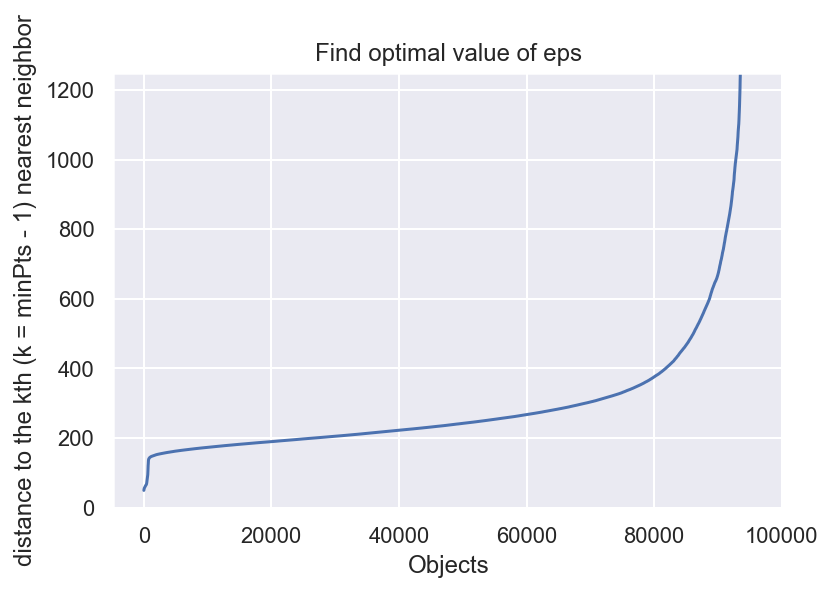

Choosing a conservative approach, eps is chosen as 400

In [ ]:
# Adapted from Data Mining Lab 11

# Perform DBSCAN clustering
dbscan = DBSCAN(eps = 500, min_samples = 300, n_jobs = -1)
dbscan_labels = dbscan.fit_predict(donors[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

In [ ]:
# Concatenating the labels to donors
dbscan_concat = pd.concat([donors, pd.Series(dbscan_labels, index=donors.index, name="dbscan_labels")], axis=1)
dbscan_concat.head()

In [ ]:
dbscan_concat.dbscan_labels.value_counts()

In [ ]:
# Detecting noise (potential outliers)
noise_points = dbscan_concat.loc[dbscan_concat['dbscan_labels'] == -1]

In [ ]:
# Get the number and share of points that are considered to pe possible outliers
outliers_dbscan = noise_points.shape[0]
total_points = donors.shape[0]
outliers_share_dbscan = round(np.divide(outliers_dbscan, total_points), 4) * 100
print('The percentage of data to remove is:', outliers_share_dbscan, '%')

In [ ]:
# Get index
index_donors = list(donors.index)

# Get noise_points index
index_noise = list(noise_points.index)

# Get the values in donors and not in noise
new_index = list(set(index_donors) - set(index_noise))

# Remove from original dataframe the observations that are in the noise dataframe
donors = donors.iloc[new_index]

# Get the new shape
donors.shape

## Data Normalization

In [ ]:
# Create a copy of the dataset
data_to_scale = donors[metric_features].copy()

In [ ]:
# Use MinMaxScaler to scale the data
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(data_to_scale)
scaled_feat

In [ ]:
# Assign the changes
donors[metric_features] = scaled_feat
donors.head(3)

### Grouping variables by categories

In [ ]:
## Remaining metric features

        # Below: Information about the donor
['ODATEDW_rel_in_days',
 'DOB_rel_in_days',
 'INCOME',
 'HIT',

        # Below: Data from third party regarding the household or neighborhood (According to David Silva) 
 'MALEMILI',
 'MALEVET',
 'VIETVETS',
 'WWIIVETS',
 'LOCALGOV',
 'STATEGOV',
 'FEDGOV',
    # Below: About donor's neighbourhood
        # Population
 'POP901',
 'POP90C1',
 'POP90C2',
 'POP90C3',
        # Provenance
 'ETH2',
 'ETH3',
 'ETH4',
 'ETH5',
 'ETH6',
 'ETH7',
 'ETH8',
 'ETH9',
 'ETH10',
 'ETH14',
 'ETH16',
        # Ages 
 'AGEC1',
 'AGEC7',
 'AC1',
 'AC2',
        # Household occupation
 'HHN5',
        # Marrital status
 'MARR2',
        # Housing type
 'DW2',
 'DW3',
 'DW4',
 'DW7',
 'DW9',
        # Housing price
 'HV1',
        # Household quantity
 'HU4',
 'HU5',
        # Household people held
 'HHD4',
 'HHD6',
 'HHD7',
 'HHD8',
 'HHD10',
 'HHD11',
 'HHD12',
        # Provenance and respective age
 'ETHC1',
 'ETHC3',
 'ETHC6',
        # Housing price
 'HVP3',
 'HVP5',
 'HUR1',
 'HUR2',
 'HUPA1',
 'HUPA3',
 'HUPA4',
 'HUPA5',
 'HUPA7',
 'RP3',
        # Income
 'IC2',
 'IC6',
 'IC19',
        # Housing and wealth
 'HHAS1',
 'HHAS2',
 'HHAS3',
 'HHAS4',
        # House moving
 'MC3',
        # Way to work (time taken)
 'TPE2',
 'TPE3',
 'TPE5',
 'TPE6',
 'TPE7',
 'TPE8',
 'TPE9',
 'PEC1',
 'PEC2',
 'TPE12',
        # Labor force ??
 'LFC10',
        # Life occupation
 'OCC1',
 'OCC2',
 'OCC3',
 'OCC4',
 'OCC5',
 'OCC6',
 'OCC7',
 'OCC8',
 'OCC10',
 'OCC11',
 'OCC12',
 'OCC13',
        # Job
 'EIC1',
 'EIC2',
 'EIC3',
 'EIC4',
 'EIC5',
 'EIC6',
 'EIC7',
 'EIC8',
 'EIC9',
 'EIC10',
 'EIC11',
 'EIC12',
 'EIC13',
 'EIC14',
 'EIC15',
 'EIC16',
 'OEDC1',
 'OEDC2',
 'OEDC3',
 'OEDC4',
 'OEDC6',
 'OEDC7',
        # Education
 'EC2',
 'EC3',
 'EC4',
 'EC6',
 'EC7',
 'EC8',
 'SEC1',
 'SEC3',
 'SEC4',
 'SEC5',
        # Military service
 'AFC2',
 'AFC3',
 'AFC6',
 'VC1',
 'VC2',
 'VC3',
 'VC4',
        # Nationality / Language
 'ANC1',
 'ANC2',
 'ANC3',
 'ANC4',
 'ANC5',
 'ANC6',
 'ANC7',
 'ANC8',
 'ANC9',
 'ANC10',
 'ANC11',
 'ANC12',
 'ANC13',
 'ANC14',
 'ANC15',
 'POBC1',
 'POBC2',
 'LSC3',
 'LSC4',
        # Vehicle Possession
 'VOC3',
        # Housing Facilities
 'HC1',
 'HC2',
 'HC3',
 'HC4',
 'HC5',
 'HC6',
 'HC8',
 'HC9',
 'HC10',
 'HC11',
 'HC12',
 'HC13',
 'HC14',
 'HC15',
 'HC16',
 'HC19',
        # Mortage
 'MHUC1',
        # Above: About donor's neighbourhood      
        # Below: Date promotion X was mailed
 # 'ADATE_2_rel_in_days',
 # 'ADATE_3_rel_in_days',
 # 'ADATE_4_rel_in_days',
 # 'ADATE_5_rel_in_days',
 # 'ADATE_6_rel_in_days',
 # 'ADATE_7_rel_in_days',
 # 'ADATE_8_rel_in_days',
 # 'ADATE_9_rel_in_days',
 # 'ADATE_10_rel_in_days',
 # 'ADATE_11_rel_in_days',
 # 'ADATE_12_rel_in_days',
 # 'ADATE_14_rel_in_days',
 # 'ADATE_16_rel_in_days',
 # 'ADATE_17_rel_in_days',
 # 'ADATE_18_rel_in_days',
 # 'ADATE_19_rel_in_days',
 # 'ADATE_21_rel_in_days',
 # 'ADATE_22_rel_in_days',
 # 'ADATE_24_rel_in_days',
 # 'MAXADATE_rel_in_days',
        # Below: Information about how many promotions donor has received
 'NUMPROM',
 # 'CARDPM12', (removed)
 # 'NUMPRM12', (removed)
        # Below: Summary variables for this donor
 'RAMNTALL',
 'NGIFTALL',
 'MINRAMNT',
 # 'MINRDATE_rel_in_days', (removed)
 'MAXRAMNT',
 # 'MAXRDATE_rel_in_days', (removed)
 'LASTGIFT',
 # 'LASTDATE_rel_in_days', (removed)
 # 'FISTDATE_rel_in_days', (removed)
 # 'NEXTDATE_rel_in_days', (removed)
 'TIMELAG',
 'AVGGIFT']

print('')

### Creating perspectives to be clustered

In [ ]:
# Information about the donor

donor_info_features = ['ODATEDW_rel_in_days',
                       'INCOME',
                       'HIT', # indicates how responsive the donor is
                       'NUMPROM' 
                      ]

donors_donor_info = donors[donor_info_features].copy()

In [ ]:
# Third party about donor

donor_third_party_features = ['MALEMILI',
                        'MALEVET',
                        'VIETVETS',
                        'WWIIVETS',
                        'LOCALGOV',
                        'STATEGOV',
                        'FEDGOV'
                      ]

donors_donor_third_party = donors[donor_third_party_features].copy()

In [ ]:
# Gifts given 

donor_gifts_given_features = ['MALEMILI',
                        'MALEVET',
                        'VIETVETS',
                        'WWIIVETS',
                        'LOCALGOV',
                        'STATEGOV',
                        'FEDGOV'
                      ]

donors_donor_gifts_given = donors[donor_gifts_given_features].copy()

In [ ]:
# Neighborhood Population

nb_population_features = ['POP901',
                         'POP90C1',
                         'POP90C2',
                         'POP90C3'
                         ]
donors_nb_population = donors[nb_population_features].copy()

In [ ]:
# Neighborhood Provenance

nb_provenance_features = ['ETH2',
                         'ETH3',
                         'ETH4',
                         'ETH5',
                         'ETH6',
                         'ETH7',
                         'ETH8',
                         'ETH9',
                         'ETH10',
                         'ETH14',
                         'ETH16'
                         ]
donors_nb_provenance = donors[nb_provenance_features].copy()

In [ ]:
# Neighborhood Ages

nb_ages_features = ['AGEC1',
                    'AGEC7',
                    'AC1',
                    'AC2'
                   ]

donors_nb_ages = donors[nb_ages_features].copy()

In [ ]:
# Neighborhood House Occupation

nb_house_occu_features = ['HHN5']

donors_nb_house_occu = donors[nb_house_occu_features].copy()

In [ ]:
# Neighborhood Marital Status

nb_marital_status_features = ['MARR2']
                   

donors_nb_marital_status = donors[nb_marital_status_features].copy()

In [ ]:
# Neighborhood Housing Type

nb_housing_type_features = ['DW2',
                            'DW3',
                            'DW4',
                            'DW7',
                            'DW9'
                           ]

donors_nb_housing_type = donors[nb_housing_type_features].copy()

In [ ]:
# Neighborhood Housing price

nb_housing_price_features = ['HV1',
                             'HVP3',
                             'HVP5',
                             'HUR1',
                             'HUR2',
                             'HUPA1',
                             'HUPA3',
                             'HUPA4',
                             'HUPA5',
                             'HUPA7',
                             'RP3'
                            ]
                   

donors_nb_housing_price = donors[nb_housing_price_features].copy()

In [ ]:
# Household quantity

nb_housing_quantity_features = ['HU4', 
                                'HU5'
                               ]

donors_nb_housing_quantity = donors[nb_housing_quantity_features].copy()

In [ ]:
# Household people held

nb_people_held_features = ['HHD4',
                            'HHD6',
                            'HHD7',
                            'HHD8',
                            'HHD10',
                            'HHD11',
                            'HHD12'
                           ]

donors_nb_people_held = donors[nb_people_held_features].copy()

In [ ]:
# Provenance and respective age

nb_provenance_and_age_features = ['ETHC1', 
                                  'ETHC3',
                                  'ETHC6'
                                 ]

donors_nb_provenance_and_age = donors[nb_provenance_and_age_features].copy()

In [ ]:
# Household people held

nb_people_held_features = ['HHD4',
                            'HHD6',
                            'HHD7',
                            'HHD8',
                            'HHD10',
                            'HHD11',
                            'HHD12'
                           ]

donors_nb_people_held = donors[nb_people_held_features].copy()

In [ ]:
# Income

nb_income_features = ['HHD4',
                      'IC2',
                      'IC6',
                      'IC19'
                    ]

donors_nb_income = donors[nb_income_features].copy()

In [ ]:
# Housing and wealth

nb_housing_and_wealth_features = ['HHAS1',
                                 'HHAS2',
                                 'HHAS3',
                                 'HHAS4'
                                ]

donors_nb_housing_and_wealth = donors[nb_housing_and_wealth_features].copy()

In [ ]:
# House moving

nb_house_moving_features = ['MC3']

donors_nb_house_moving = donors[nb_house_moving_features].copy()

In [ ]:
# Way to work (time taken)

nb_way_to_work_features = ['TPE2',
                         'TPE3',
                         'TPE5',
                         'TPE6',
                         'TPE7',
                         'TPE8',
                         'TPE9',
                         'PEC1',
                         'PEC2',
                         'TPE12'
                        ]

donors_nb_way_to_work = donors[nb_way_to_work_features].copy()

In [ ]:
# Labor force ??

nb_labor_force_features = ['LFC10']

donors_nb_labor_force = donors[nb_labor_force_features].copy()

In [ ]:
# Life occupation

nb_life_occu_features = ['OCC1',
                         'OCC2',
                         'OCC3',
                         'OCC4',
                         'OCC5',
                         'OCC6',
                         'OCC7',
                         'OCC8',
                         'OCC10',
                         'OCC11',
                         'OCC12',
                         'OCC13'
                        ]

donors_nb_life_occu = donors[nb_life_occu_features].copy()

In [ ]:
# Job

nb_job_features = ['EIC1',
                 'EIC2',
                 'EIC3',
                 'EIC4',
                 'EIC5',
                 'EIC6',
                 'EIC7',
                 'EIC8',
                 'EIC9',
                 'EIC10',
                 'EIC11',
                 'EIC12',
                 'EIC13',
                 'EIC14',
                 'EIC15',
                 'EIC16',
                 'OEDC1',
                 'OEDC2',
                 'OEDC3',
                 'OEDC4',
                 'OEDC6',
                 'OEDC7'
                  ]

donors_nb_job = donors[nb_job_features].copy()

In [ ]:
# Education

nb_education_features = ['EC2',
                 'EC3',
                 'EC4',
                 'EC6',
                 'EC7',
                 'EC8',
                 'SEC1',
                 'SEC3',
                 'SEC4',
                 'SEC5'
                  ]

donors_nb_education = donors[nb_education_features].copy()

In [ ]:
# Military Service

nb_military_service_features = ['AFC2',
                         'AFC3',
                         'AFC6',
                         'VC1',
                         'VC2',
                         'VC3',
                         'VC4'
                        ]

donors_nb_military_service = donors[nb_military_service_features].copy()

In [ ]:
# Nationality

nb_nationality_features = ['ANC1',
                         'ANC2',
                         'ANC3',
                         'ANC4',
                         'ANC5',
                         'ANC6',
                         'ANC7',
                         'ANC8',
                         'ANC9',
                         'ANC10',
                         'ANC11',
                         'ANC12',
                         'ANC13',
                         'ANC14',
                         'ANC15',
                         'POBC1',
                         'POBC2',
                         'LSC3',
                         'LSC4'
                        ]

donors_nb_nationality = donors[nb_nationality_features].copy()

In [ ]:
# Vehicle Possesion

nb_vehicle_poss_features = ['VOC3']

donors_nb_vehicle_poss = donors[nb_vehicle_poss_features].copy()

In [ ]:
# Housing Facilities

nb_housing_facilities_features = ['HC1',
                                 'HC2',
                                 'HC3',
                                 'HC4',
                                 'HC5',
                                 'HC6',
                                 'HC8',
                                 'HC9',
                                 'HC10',
                                 'HC11',
                                 'HC12',
                                 'HC13',
                                 'HC14',
                                 'HC15',
                                 'HC16',
                                 'HC19'
                            ]

donors_nb_housing_facilities = donors[nb_housing_facilities_features].copy()

In [ ]:
# Mortage

nb_mortage_features = ['MHUC1']

donors_nb_mortage = donors[nb_mortage_features].copy()

## Clustering

In [ ]:
# Store here every perspective and assign a name to use further ahead

# Discard those that intuitively make less sense to use

df_to_cluster = [[donors_donor_info, '_donor_info'],
                 [donors_donor_third_party, '_donor_third_party'],
                 [donors_donor_gifts_given, '_donor_gifts_given'],
                 [donors_nb_population, '_nb_population'],
                 [donors_nb_provenance, '_nb_provenance'],
                 [donors_nb_ages, '_nb_ages'],
                 # [donors_nb_house_occu, '_nb_house_occu'],
                 # [donors_nb_marital_status, '_nb_marital_status'],
                 # [donors_nb_housing_type, '_nb_house_type'],
                 [donors_nb_housing_price, '_nb_house_price'],
                 [donors_nb_housing_quantity, '_nb_house_quant'],
                 [donors_nb_people_held, '_nb_people_held'],
                 [donors_nb_income, '_nb_income'],
                 # [donors_nb_housing_and_wealth, '_nb_housing_wealth'],
                 [donors_nb_house_moving, '_nb_house_moving'],
                 # [donors_nb_way_to_work, '_nb_way_to_work'],
                 # [donors_nb_labor_force, '_nb_labor_force'],
                 [donors_nb_life_occu, '_nb_life_occu'],
                 [donors_nb_job, '_nb_job'],
                 [donors_nb_education, '_nb_education'],
                 [donors_nb_military_service, '_nb_military_service'],
                 # [donors_nb_nationality, '_nb_nationality'],
                 # [donors_nb_vehicle_poss, '_nb_vehicle_poss'],
                 # [donors_nb_housing_facilities, '_nb_house_facilities'],
                 # [donors_nb_mortage, '_nb_mortage']
                ]

# Check the number of perspective
len(df_to_cluster)

In [ ]:
for df, name in df_to_cluster:
    print('')
    print(name)
    for feature in df.columns.to_list():
        print('')
        print(feature)
        print(gini(df[feature]))
        print('')
    print('')
    print('=============')
    print('')

### KMeans + HC

#### Trying to cluster for population variables

Since we have around 100 000 observations, HC can reveal to be unsuitable. Because of this we will run KMeans with k = 150 firstly and apply HC on top of those results.

We will still try to cluster by prespectives in a first approach in order to keep as much info as possible.

In [ ]:
# Initialize KMeans
kmeans = KMeans(n_clusters = 1000,
                 init = 'k-means++',
                 n_init = 10, # number of times KMeans is initialized 
                 random_state = 1)

TESTING THE IDEA WITH POPULATION. THE IDEA IS TO THEN DO A FOR WITH ALL THE DATASETS PRESPECTIVES AND CLUSTER EACH ONE

In [ ]:
# Testing for population
kmeans_labels = kmeans.fit_predict(donors_nb_population)
kmeans_labels

In [ ]:
# Characterizing the final clusters
df_concat_pop = pd.concat((donors_nb_population, pd.Series(kmeans_labels, name='labels')), axis=1)
df_concat_pop.groupby('labels').mean()

In [ ]:
# Find Nan values 
nans_index_t = df_concat_pop.isna().any(axis=1)
df_concat_pop[nans_index_t]

In [ ]:
if False:
    # KNNImputer - only works for numerical variables
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    df_concat_pop = imputer.fit_transform(df_concat_pop)

In [ ]:
if False:
    # Save the result in a dataframe
    df_concat_pop = pd.DataFrame(df_concat_pop)

In [ ]:
if False:
    # Apply HC on the results

    # !!!!! UNDERSTAND HOW DID THE NANS CAME UP !!!!!!!

    # Instance to store the results
    r2_scores = {}

    # Initialize the HC method
    hierarchical = AgglomerativeClustering(
        affinity='euclidean'
    )

    # Find the best linkage
    for linkage in ['single']:
        r2_scores[linkage] = get_r2_scores(
            df_concat_pop, hierarchical.set_params(linkage=linkage)
        )

    pd.DataFrame(r2_scores)

### SOM + KMeans

In [ ]:
# Create a function that runs KMeans on top of SOM
def KMeans_on_SOM (df, name, final_df):
    
    # Initialize the SOM instance
    sm = sompy.SOMFactory().build(
    df.values, 
    mapsize=(50, 50),
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=df.columns
    )
    
    # Train the algorithm
    sm.train(n_job=-1, verbose= None, train_rough_len=100, train_finetune_len=100)
    
    # Visualizing the Component planes (feature values)
    sns.set()
    view2D = View2D(12,12,"", text_size=10)
    view2D.show(sm, col_sz=3, what='codebook')
    plt.subplots_adjust(top=0.90)
    plt.suptitle("Component Planes", fontsize=20)
    plt.show()
    
    # Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
    kmeans = KMeans(n_clusters=7, init='k-means++', n_init=20, random_state=42)
    nodeclus_labels = sm.cluster(kmeans)

    hits  = HitMapView(12, 12,"Clustering", text_size=10)
    hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

    plt.show()
    
    # Get the nodes and and respective clusters
    nodes = sm.get_node_vectors()
    
    globals()['df_nodes' + name] = pd.DataFrame(nodes, columns=df.columns)
    globals()['df_nodes' + name]['label' + name] = nodeclus_labels
    
    # Obtaining SOM's BMUs labels
    bmus_map = sm.find_bmu(donors_nb_population)[0]  # get bmus for each observation in df

    globals()['df_bmus' + name] = pd.DataFrame(
        np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
        index=df.index, columns=np.append(df.columns,"BMU")
    )
    
    # Get cluster labels for each observation
    globals()['df_final' + name] = globals()['df_bmus' + name].merge(globals()['df_nodes' + name]['label' + name], 'left', left_on="BMU", right_index=True)
    globals()['df_final' + name]
    
    # Characterizing the final clusters for a perspective
    globals()['df_final' + name].drop(columns='BMU').groupby('label' + name).mean()
    
    # Add this label to the final df
    final_df[name] = globals()['df_final' + name]['label' + name]
    
    sst = get_ss(globals()['df_final' + name])  # get total sum of squares
    ssw_labels = globals()['df_final' + name][df.columns.to_list() + ["label" + name]].groupby(by='label' + name).apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
    r2 = ssb / sst
    
    print('The r2 for ' + name + ' cluster solution is: ', r2)

In [ ]:
# Apply KMeans on top of SOM for each perspective

# Create a df to store the final results
final_df = pd.DataFrame()

# Loop over the list
for df, name in df_to_cluster:
    print('')
    print('')
    print('================================================')
    print('CLUSTERING FOR:', name)
    print('================================================')
    print('')
    start = time.time()
    KMeans_on_SOM(df, name, final_df)
    end = time.time()
    dur = end - start
    print('The duration of ' + name + ' cluster solution was: ', dur)

In [ ]:
# Characterizing the final clusters
df_final.drop(columns='BMU').groupby('label').mean()

#### ------------------------------------------------

In [199]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        print('n_clusters =', n)
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

if False:
    # Set up the clusterers
    kmeans = KMeans(
        init='k-means++',
        random_state=42
    )

    hierarchical = AgglomerativeClustering(
        affinity='euclidean'
    )

### Finding the optimal clusterer on individual's info and motivation variables

In [166]:
df_1 = two_perspectives_data_imputed_no_outlier_scaled[perspective_1].copy()
df_2 = two_perspectives_data_imputed_no_outlier_scaled[perspective_2].copy()

In [167]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_1, kmeans)

n_clusters = 2
n_clusters = 3
n_clusters = 4
n_clusters = 5
n_clusters = 6
n_clusters = 7
n_clusters = 8
n_clusters = 9


In [168]:
clust = clone(hierarchical)
clust.set_params(n_clusters=2, linkage='complete')

AgglomerativeClustering(linkage='complete')

In [ ]:
labels = clust.fit_predict(df_1)

In [ ]:
for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_1, hierarchical.set_params(linkage=linkage)
    )

In [ ]:
pd.DataFrame(r2_scores)

In [ ]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Variables about info on individual and individual's motivation:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()